In [1]:
#import custom modules
from importlib import reload
from helpers.my_imports import *
import helpers.preprocessing as pp
import helpers.plot as plot
import helpers.tools as tools
import helpers.transformers as xfrs
from helpers.reload import myreload

#make sure latest copy of library is loaded
myreload()

#Global Variable for Random State
rs=42 #random_state

#Reload dataframe
df = pd.read_csv('saved_dfs/preprocessed_negotiations_df.csv')
df.head(2)

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


,claim_type,NSA_NNSA,split_claim,negotiation_type,in_response_to,level,facility,carrier,group_number,plan_funding,TPA,TPA_rep,billed_amount,negotiation_amount,offer,counter_offer,decision,service_days,decision_days,offer_days,counter_offer_days,YOB,neg_to_billed,offer_to_neg,offer_to_counter_offer
0,HCFA,NNSA,No,NNSA Negotiation,Insurance Initiated,Level 3,Cedar Hill,Cigna,3344605,FULLY,Zelis,Marissa Pepe,4058.0,4058.0,258.0,3449.0,Rejected,128.0,NaN,0.0,0.0,1984,1.0,0.0636,0.0748
1,UB,NNSA,No,NNSA Negotiation,Insurance Initiated,Level 5,Cedar Hill,Blue Cross Blue Shield,174518M3BH,SELF,Zelis,Courtney Kiernan,52253.0,52253.0,12500.0,44415.0,Rejected,127.0,NaN,2.0,2.0,2021,1.0,0.2392,0.2814


## Plan for Hyperparameter Tuning
- Since the previous round of testing did not include parameters, we take these results with a grain of salt. In other words we will retest with various scalers, transformers and encoders in this section
- For Hyperparameter Tuning, we will break up the testing into two groups:
  - Group 1: LogisticRegression and RidgeClassifier
  - Group 2: RandomForestClassifier and GradientBoostingClassifier 

## Define X, y
Redefine X and y based on what we learned in Feature Engineering

In [2]:
#Define X and y
X,y=df.drop(columns=['decision', 'billed_amount', 'negotiation_amount', 'offer', 'counter_offer']), df.decision

#Split and stratify the data
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6398, 20), (2133, 20), (6398,), (2133,))

## Cross-Validation with HyperParameter Tuning
We will use a function `build_and_run_pipes` for this notebook that splits the dataset into training and testing sets,  dynamically builds transformer and pipeline to include imputers, polynomial features, numerical transformers, rare category combiners, scalers, encoders, selectors, etc, performs hyperparameter tuning using specified search methods, and evaluates model performance using both cross-validation and holdout validation. It supports GridSearchCV, RandomizedSearchCV,and HalvingRandomSearchCV for hyperparameter tuning. Results are presented in 3 DataFrames as follows: 
  - cvresults_ enhanced with holdout results and sorted by descending order of Cross-Validation rank
  - models sorted from best to worse by descending order of holdout validation rank. It also prioritizes models that are not overfit 
    even if those scores are lower
  - If multiple estimators are evaluated, it creates a third dataframe displaying the best holdout results from each estimator
  - Finally the function optionally plots model performance.

### General Setup

#### Define Scoring Metrics

In [3]:
#Define Primary and Secondary Scoring Metrics as established in EDA
scoring_metrics = {
    'f1': make_scorer(f1_score, average='binary', pos_label='Accepted', zero_division=0.0),
    'precision': make_scorer(precision_score, average='binary', pos_label='Accepted', zero_division=0.0)}

#### Define dict of class weights

In [4]:
#Calculate minority class weight
minority_class_weight = round(y_train.value_counts().iloc[1]/len(y_train),4)
print(f"The ratio of Accepted to Rejected in dataset is: {minority_class_weight:.3f}")

#Define set of class_weights that may help address the imbalance.
class_weights=[{'Accepted': minority_class_weight, 'Rejected': 1}, 
               {'Accepted': minority_class_weight*1.5, 'Rejected': 1},
               {'Accepted': minority_class_weight*2, 'Rejected': 1},
               {'Accepted': minority_class_weight*3, 'Rejected': 1},
               {'Accepted': minority_class_weight*4, 'Rejected': 1}, 
               {'Accepted': minority_class_weight*5, 'Rejected': 1}]

The ratio of Accepted to Rejected in dataset is: 0.104


### Logistic Regression and RidgeClassifier

In [5]:
lgr_ridge_dicts =[
    {
        'est_tuple': ('lgr', LogisticRegression(verbose=0, fit_intercept=True, random_state=rs, n_jobs=-1)), 
        'est_params': {
            'penalty': ['l2'],
            'C': loguniform(1e-5, 1e2), #larger C stronger regularization, risk of overfitting
            'solver': ['newton-cholesky'], #liblinear not great for large datasets 
            'max_iter': [5000], 
            'class_weight': class_weights,
            'tol': loguniform(5e-7, 1e-4),
        }, 
    },
    {
        'est_tuple': ('ridge', RidgeClassifier(fit_intercept=True, random_state=rs)), 
        'est_params': {
            'alpha': loguniform(1e-2, 1e2), 
            'tol': loguniform(1e-5, 1e-2),
            'class_weight': class_weights, 
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], #'lbfgs' only when positive
        }
    }]

#### Set1: Simple Imputer, yeo_johnson, polynomial features, rare category combiner, TargetEncoder, 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.640496,Yes,0.647430,0.646739,0.700775,0.799640,29.706763,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",5000,l2,newton-cholesky,0.000020,0.000003,0.002500,1,None,16
2,0.638968,Yes,0.672582,0.646240,0.717752,0.798109,28.387010,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",5000,l2,newton-cholesky,0.000001,0.000001,0.010000,1,None,17
3,0.622843,Yes,0.656987,0.640669,15.114424,0.829813,0.284661,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,0.000080,0.010000,3,None,15
4,0.522355,Yes,0.563786,0.553459,3.299946,0.852213,16.382897,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000001,0.000002,0.007500,2,if_binary,14


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
7,0.481896,No,0.506952,0.554140,0.697467,0.858873,43.873144,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.00001,0.000006,0.0025,1,None,11,1
8,0.470790,No,0.496208,0.546032,3.355255,0.879923,0.616072,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000001,0.000009,0.005,2,if_binary,10,2
6,0.487689,No,0.499462,0.520900,0.769111,0.856618,61.569973,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000072,0.000001,0.0075,1,if_binary,12,3
9,0.467947,No,0.486065,0.501672,13.649766,0.898996,22.013622,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000034,0.00001,0.0075,3,None,9,4


<Figure size 640x480 with 0 Axes>

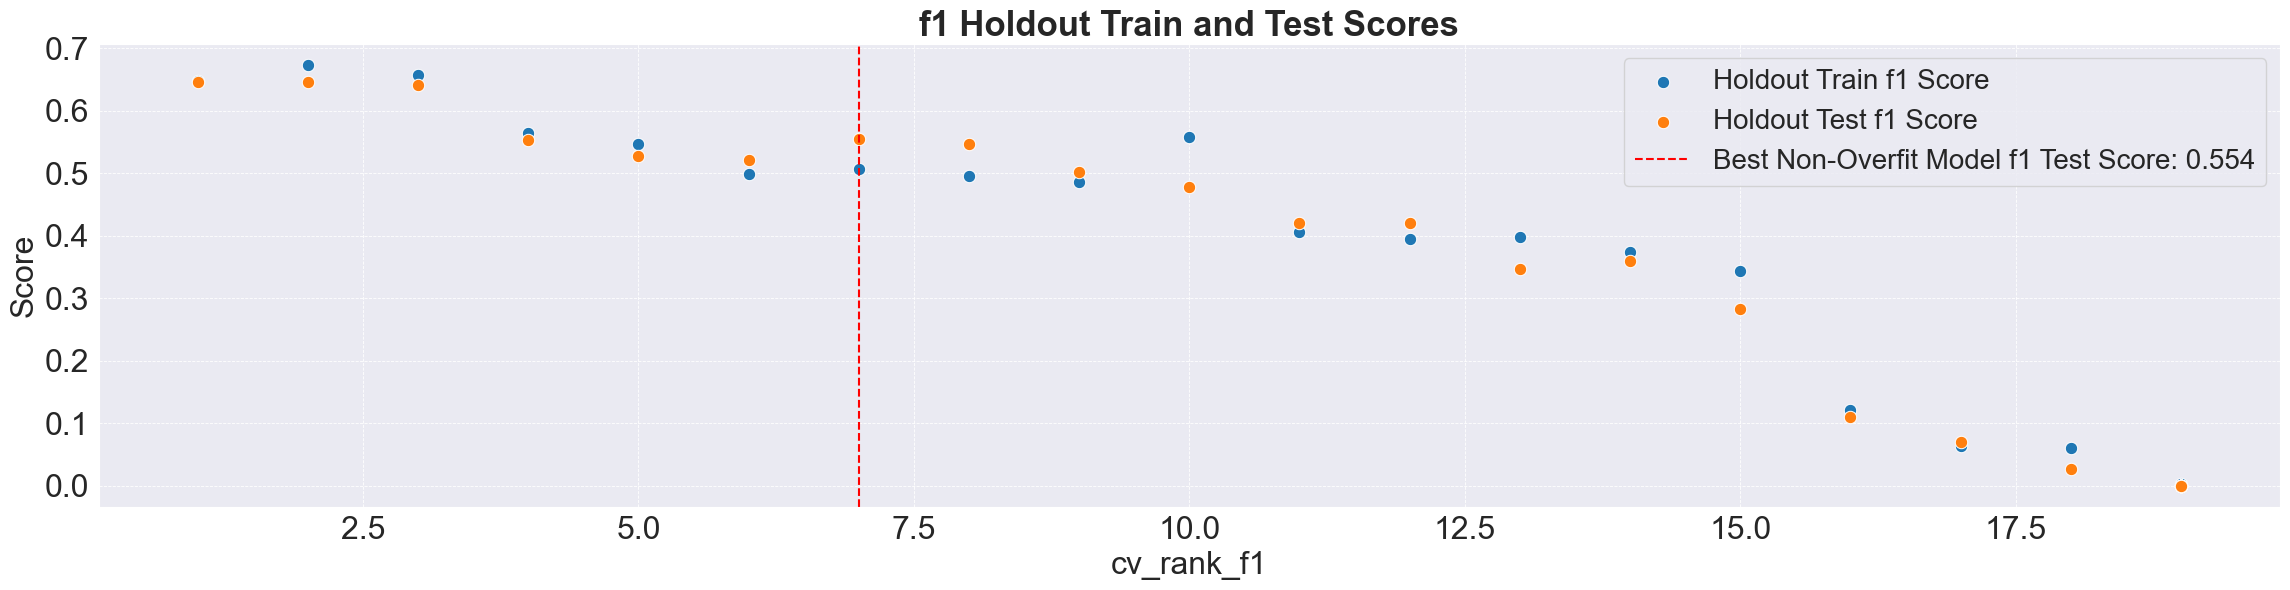

Fitting 5 folds for each of 40 candidates, totalling 200 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_ridge__alpha,param_ridge__class_weight,param_ridge__solver,param_ridge__tol,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.499307,Yes,0.612043,0.495298,16.233306,0.849021,0.044311,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",lsqr,0.000552,0.000005,0,3,if_binary,9
2,0.498961,Yes,0.612648,0.495298,16.391397,0.848974,0.023037,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",cholesky,0.000140,0.000083,0,3,if_binary,10
3,0.416458,Yes,0.425821,0.414966,3.596541,0.840567,1.758364,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",saga,0.000013,0.000024,0.002500,2,None,12
4,0.351570,No,0.338129,0.364912,3.523480,0.845893,21.368329,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",svd,0.000035,0.000002,0.007500,2,None,11


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_ridge__alpha,param_ridge__class_weight,param_ridge__solver,param_ridge__tol,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
6,0.299692,No,0.364072,0.423611,16.221976,0.869281,0.314891,"{'Accepted': 0.4172, 'Rejected': 1}",saga,0.00157,0.000015,0.0025,3,if_binary,6,1
4,0.351570,No,0.338129,0.364912,3.523480,0.845893,21.368329,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",svd,0.000035,0.000002,0.0075,2,None,11,2
8,0.170879,No,0.149584,0.223108,17.102694,0.922381,0.201296,"{'Accepted': 0.3129, 'Rejected': 1}",cholesky,0.00136,0.000038,0.0075,3,None,4,3
7,0.193685,No,0.204787,0.214286,3.402531,0.891952,0.017074,"{'Accepted': 0.4172, 'Rejected': 1}",lsqr,0.000027,0.000019,0.01,2,None,5,4


<Figure size 640x480 with 0 Axes>

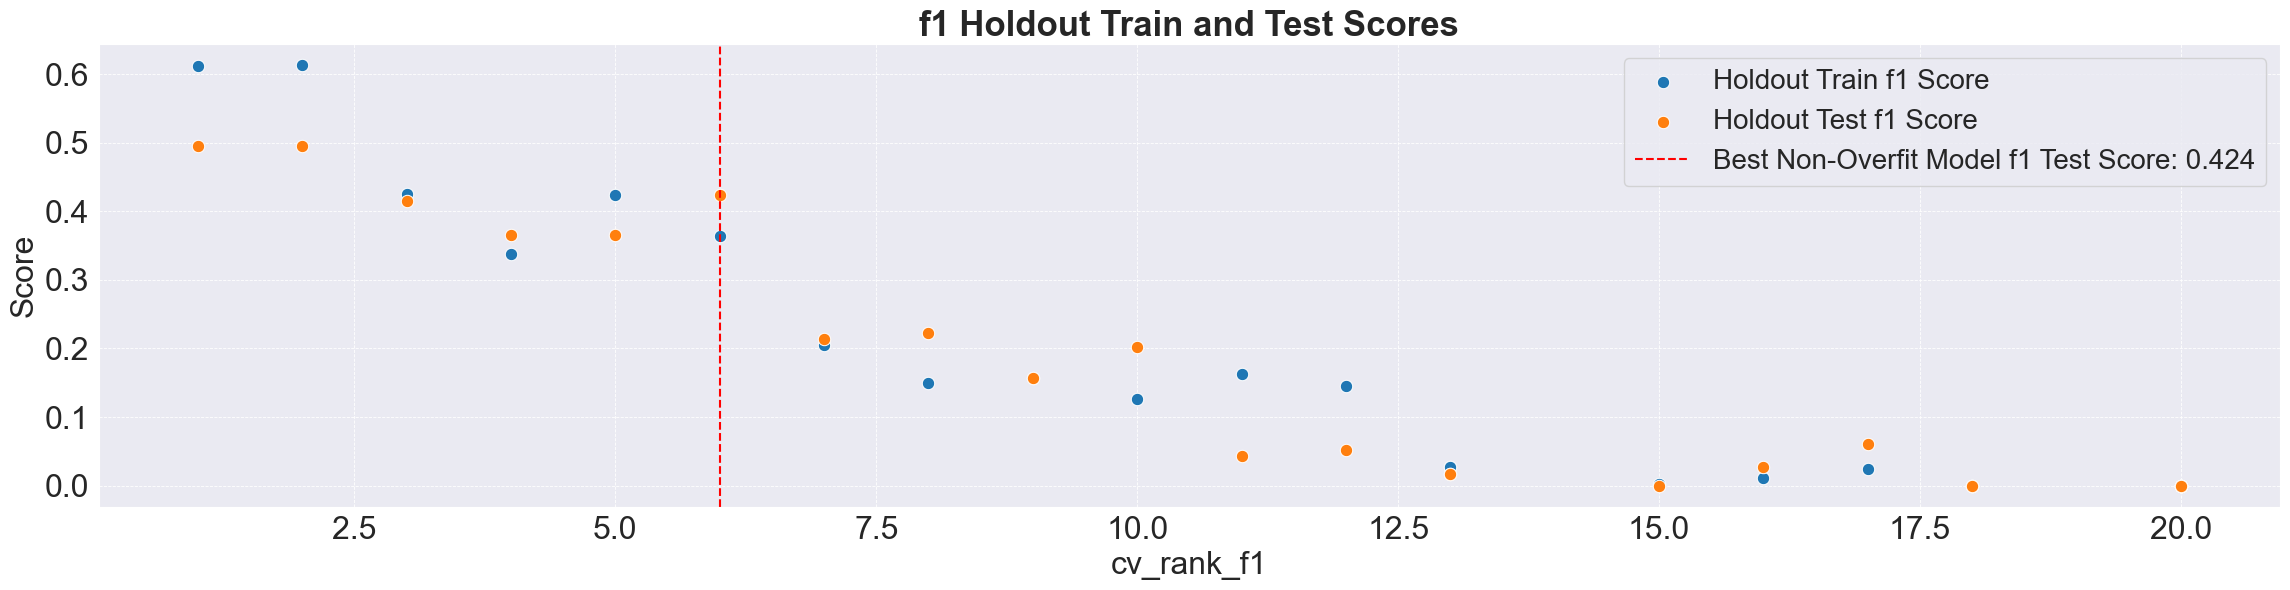

model,train f1 score,test f1 score,mean fit time,mean_test_precision
lgr,0.506952,0.554140,0.697467,0.858873
ridge,0.364072,0.423611,16.221976,0.869281


In [9]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),        
    poly_params={'transformer__num__poly__degree':[1,2,3]}, 
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075, 0.01]},
    
    cat_encoder=('rest_encoder', TargetEncoder(target_type='binary', random_state=rs)),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary', None]},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
    oversampler= None, undersampler=None , #Using class_weights instead              
    scaler=('scaler', MinMaxScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 9e-5) },  
    
    estimator_dicts = lgr_ridge_dicts, set_name= 'ht_lgr_ridge_set1',         
    cv=5, n_iter=40, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

Since LogisticRegression did much better and since we were only interested in RidgeClassifier because of its potential for really high Precision, and we are not seeing that, we will drop the RidgeClassifier
#### Set2: Shrink range of C,  increase tol and rare_to_value, set ohe_drop to if_binary

Fitting 5 folds for each of 60 candidates, totalling 300 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.655719,Yes,0.676032,0.661247,0.764055,0.800654,51.444413,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,0.000001,0.007500,1,if_binary,45
1,0.655719,Yes,0.676032,0.661247,0.785742,0.800654,59.805418,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,0.000008,0.007500,1,if_binary,45
3,0.653679,Yes,0.674336,0.655827,3.467078,0.797773,86.556415,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",5000,l2,newton-cholesky,0.000080,0.000035,0.005000,2,if_binary,53
4,0.649959,Yes,0.677277,0.653951,3.544013,0.799631,12.276071,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",5000,l2,newton-cholesky,0.000008,0.000007,0.005000,2,if_binary,51


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
14,0.594272,No,0.635445,0.646409,0.728696,0.800548,0.964206,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",5000,l2,newton-cholesky,0.000001,0.00001,0.0075,1,if_binary,47,1
15,0.586717,No,0.624535,0.636872,0.664605,0.809089,0.695744,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",5000,l2,newton-cholesky,0.000022,0.000027,0.0075,1,if_binary,43,2
16,0.583102,No,0.606292,0.625731,0.725255,0.824598,31.421555,"{'Accepted': 0.4172, 'Rejected': 1}",5000,l2,newton-cholesky,0.000005,0.000026,0.0075,1,if_binary,39,3
12,0.595598,No,0.619981,0.621469,3.411899,0.814398,0.222651,"{'Accepted': 0.5215000000000001, 'Rejected': 1}",5000,l2,newton-cholesky,0.000019,0.000008,0.0075,2,if_binary,42,4


<Figure size 640x480 with 0 Axes>

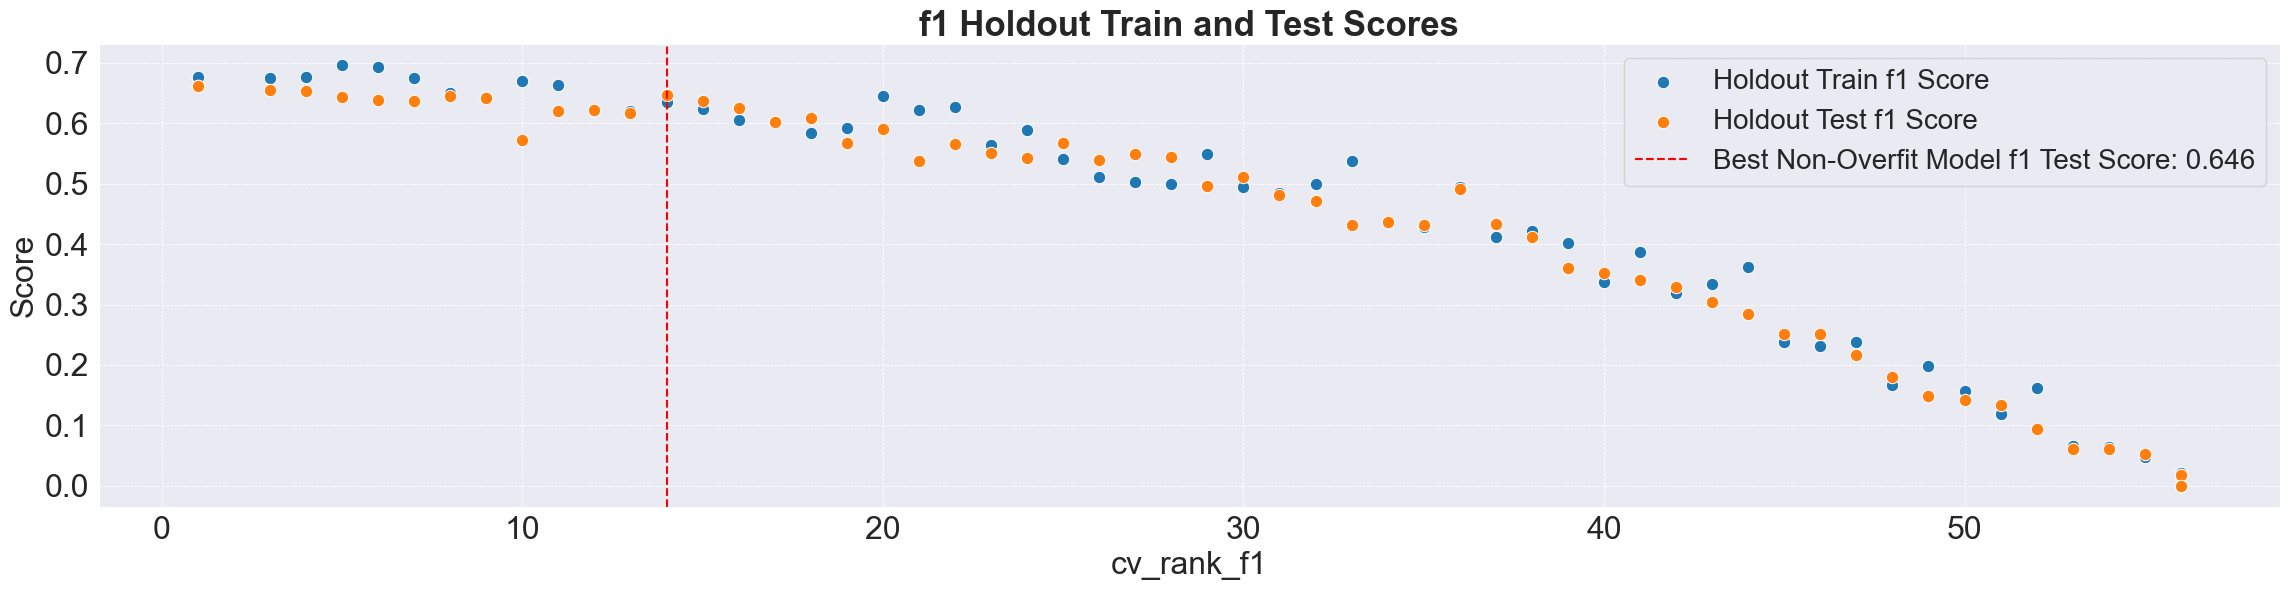

In [11]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),        
    poly_params={'transformer__num__poly__degree':[1,2]}, 
    num_cols=['neg_to_billed','offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075]},
    
    cat_encoder=('rest_encoder', TargetEncoder(target_type='binary', random_state=rs)),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                   
    scaler=('scaler', MinMaxScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(7e-7, 5e-5) }, 
    estimator_dicts = [{
        'est_tuple': ('lgr', LogisticRegression(verbose=0, fit_intercept=True, random_state=rs, n_jobs=-1)), 
        'est_params': {
            'penalty': ['l2'],
            'C': loguniform(7e-2, 9e1), 
            'solver': ['newton-cholesky'], 
            'max_iter': [5000], 
            'class_weight': class_weights,
            'tol': loguniform(7e-7, 1e-4),
        }, },], set_name= 'ht_lgr_set2',         
    cv=5, n_iter=60, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

#### Set 3 - Try with oversampler/undersampler

Fitting 5 folds for each of 60 candidates, totalling 300 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.729554,No,0.737683,0.751515,1.830236,0.663047,1.321411,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,152,0.450000,0.000014,0.007500,2,if_binary,25
2,0.729531,Yes,0.752159,0.734864,0.419919,0.660144,48.926438,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000029,176,0.500000,0.000004,0,1,if_binary,27
3,0.727349,No,0.744063,0.752033,0.362474,0.657603,41.705460,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000003,231,0.400000,0.000003,0,1,if_binary,29
4,0.726822,No,0.734777,0.736402,1.729869,0.669913,0.190827,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000003,156,0.400000,0.000001,0.002500,2,if_binary,22


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
22,0.715269,No,0.734448,0.759184,1.874741,0.650959,6.938525,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000073,243,0.475,0.000008,0.0075,2,if_binary,32,1
17,0.718690,No,0.752957,0.754564,1.313732,0.648235,59.189973,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000041,213,0.45,0.000002,0,2,if_binary,34,2
30,0.711528,No,0.726356,0.753346,1.873824,0.625589,86.498776,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000024,172,0.5,0.000002,0.0075,2,if_binary,37,3
3,0.727349,No,0.744063,0.752033,0.362474,0.657603,41.70546,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000003,231,0.4,0.000003,0,1,if_binary,29,4


<Figure size 640x480 with 0 Axes>

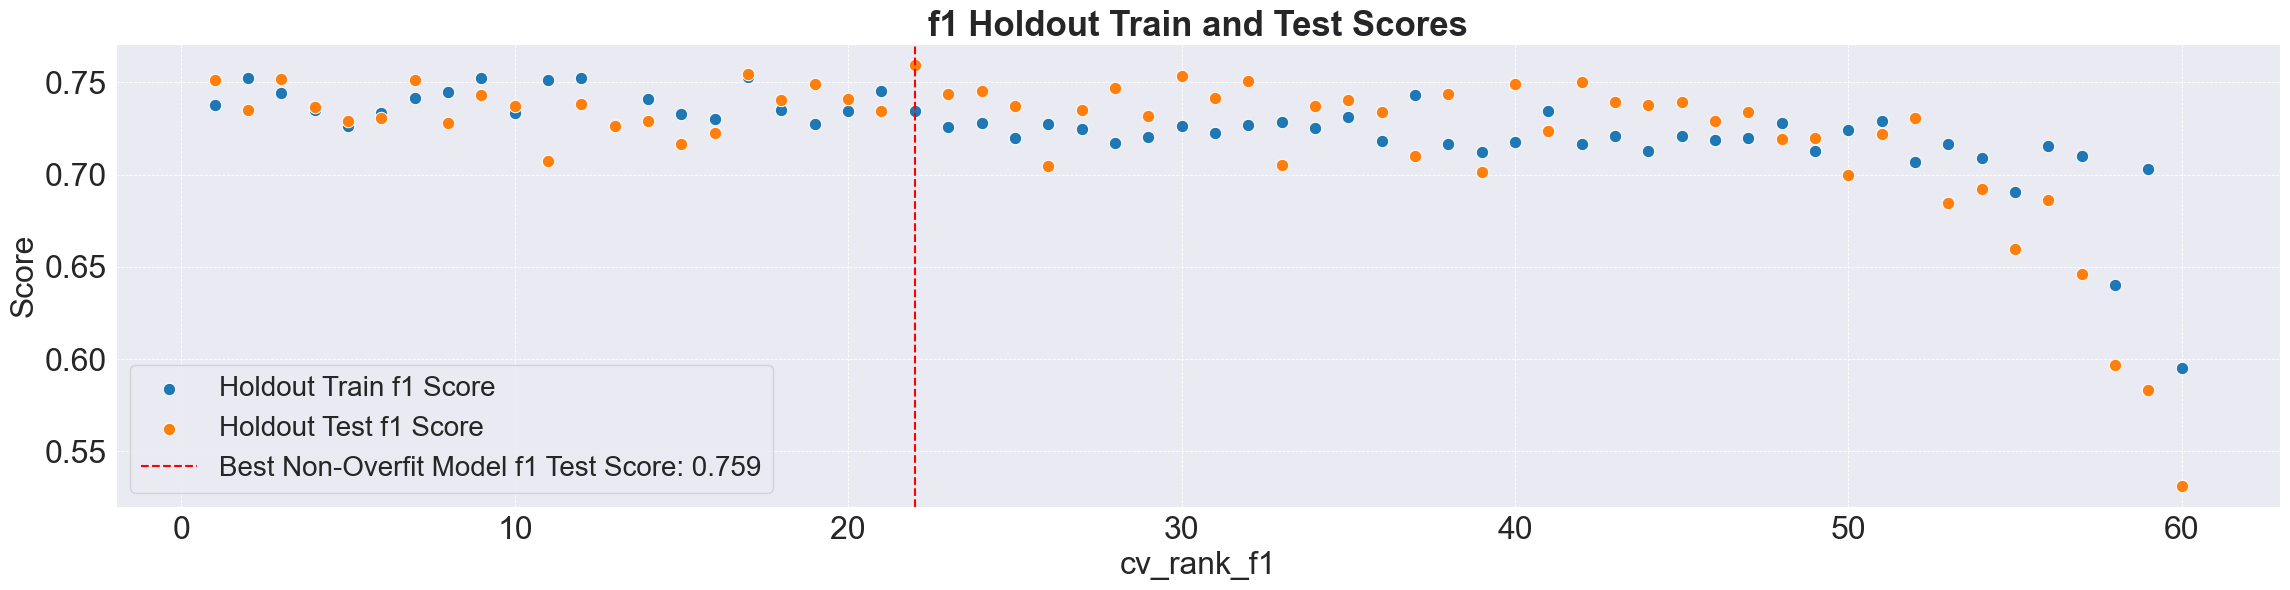

In [13]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),        
    poly_params={'transformer__num__poly__degree':[1,2]}, 
    num_cols=['neg_to_billed','offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075]},
    
    cat_encoder=('rest_encoder', TargetEncoder(target_type='binary', random_state=rs)),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),
                   
    scaler=('scaler', MinMaxScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(7e-7, 5e-5) }, 
    estimator_dicts = [{
        'est_tuple': ('lgr', LogisticRegression(verbose=0, fit_intercept=True, random_state=rs, n_jobs=-1)), 
        'est_params': {
            'penalty': ['l2'],
            'C': loguniform(7e-2, 9e1), 
            'solver': ['newton-cholesky'], 
            'max_iter': [5000], 
            'class_weight': class_weights,
            'tol': loguniform(7e-7, 1e-4),
        }, },], set_name= 'ht_lgr_set3',         
    cv=5, n_iter=60, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

#### Set 4 - Try with QuantileTransformer

Fitting 5 folds for each of 60 candidates, totalling 300 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.732281,Yes,0.749828,0.725738,0.386586,0.687257,49.048953,"{'Accepted': 0.15645, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,257,0.400000,0.000012,0,1,if_binary,12
2,0.729634,No,0.736278,0.745418,0.671051,0.660194,14.415566,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000018,172,0.475000,0.000006,0.002500,1,if_binary,23
3,0.726098,No,0.732262,0.737271,7.472974,0.661354,1.321411,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,152,0.450000,0.000014,0.007500,2,if_binary,22
4,0.725588,Yes,0.755401,0.733475,4.621784,0.683299,3.663492,"{'Accepted': 0.15645, 'Rejected': 1}",5000,l2,newton-cholesky,0.000039,238,0.425000,0.000028,0,2,if_binary,14


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
10,0.722853,No,0.750000,0.760163,5.418113,0.655203,59.189973,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000041,213,0.45,0.000002,0,2,if_binary,28,1
19,0.715871,No,0.725983,0.754352,7.823091,0.626050,86.498776,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000024,172,0.5,0.000002,0.0075,2,if_binary,37,2
22,0.713237,No,0.726343,0.753788,7.461387,0.620631,70.178718,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000046,255,0.45,0.000011,0.0075,2,if_binary,40,3
16,0.716727,No,0.724160,0.751908,4.880034,0.623287,75.711724,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000024,286,0.4,0.000004,0.005,2,if_binary,39,4


<Figure size 640x480 with 0 Axes>

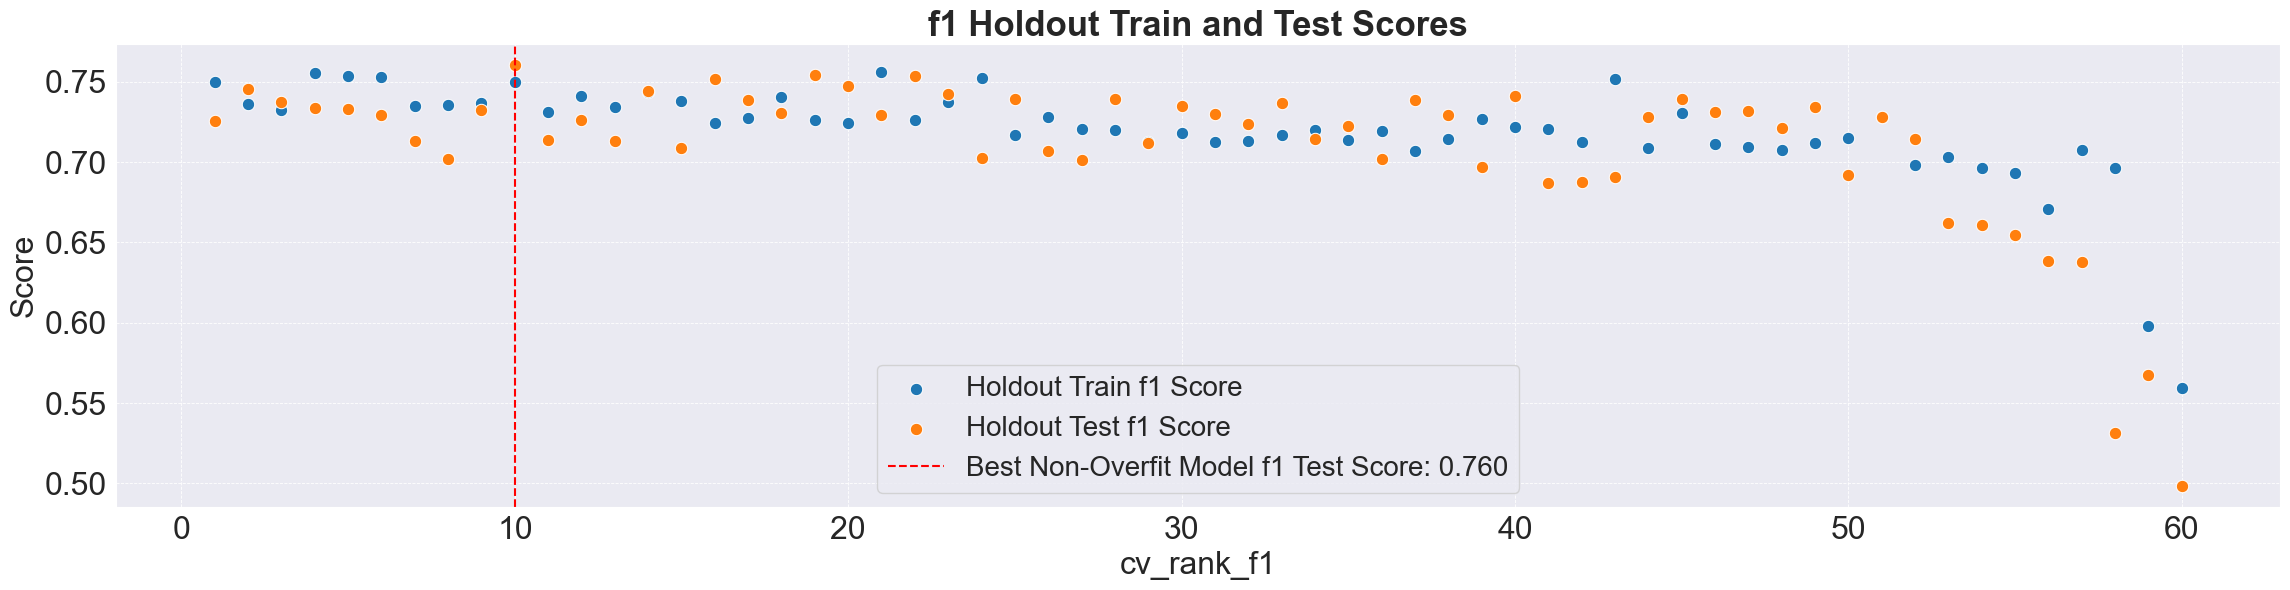

In [14]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', QuantileTransformer(random_state=rs)),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),        
    poly_params={'transformer__num__poly__degree':[1,2]}, 
    num_cols=['neg_to_billed','offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075]},
    
    cat_encoder=('rest_encoder', TargetEncoder(target_type='binary', random_state=rs)),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),
                   
    scaler=('scaler', MinMaxScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(7e-7, 5e-5) }, 
    estimator_dicts = [{
        'est_tuple': ('lgr', LogisticRegression(verbose=0, fit_intercept=True, random_state=rs, n_jobs=-1)), 
        'est_params': {
            'penalty': ['l2'],
            'C': loguniform(7e-2, 9e1), 
            'solver': ['newton-cholesky'], 
            'max_iter': [5000], 
            'class_weight': class_weights,
            'tol': loguniform(7e-7, 1e-4),
        }, },], set_name= 'ht_lgr_set4',         
    cv=5, n_iter=60, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

While we did get a better model, there the next best models were not as good as with yeo_johnson so we will keep yeo_johnson for now

#### Set 5 - Try with Binary Encoder

Fitting 5 folds for each of 60 candidates, totalling 300 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.736516,No,0.744912,0.755187,2.332703,0.673600,6.938525,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000073,243,0.475000,0.000008,0.007500,2,if_binary,24
2,0.733123,Yes,0.740791,0.740426,1.075275,0.674327,0.792849,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000023,270,0.475000,0.000031,0.007500,1,if_binary,22
3,0.732992,No,0.743590,0.767635,2.241522,0.670800,1.321411,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,152,0.450000,0.000014,0.007500,2,if_binary,26
4,0.728656,No,0.740533,0.767241,2.376384,0.686499,3.377054,"{'Accepted': 0.15645, 'Rejected': 1}",5000,l2,newton-cholesky,0.000003,283,0.425000,0.000046,0.007500,2,if_binary,15


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
3,0.732992,No,0.743590,0.767635,2.241522,0.670800,1.321411,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,152,0.45,0.000014,0.0075,2,if_binary,26,1
4,0.728656,No,0.740533,0.767241,2.376384,0.686499,3.377054,"{'Accepted': 0.15645, 'Rejected': 1}",5000,l2,newton-cholesky,0.000003,283,0.425,0.000046,0.0075,2,if_binary,15,2
15,0.717572,No,0.735484,0.766798,2.813824,0.637008,0.43108,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,269,0.45,0.000003,0,2,if_binary,36,3
13,0.717956,No,0.742045,0.763265,0.896440,0.658028,48.926438,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000029,176,0.5,0.000004,0,1,if_binary,32,4


<Figure size 640x480 with 0 Axes>

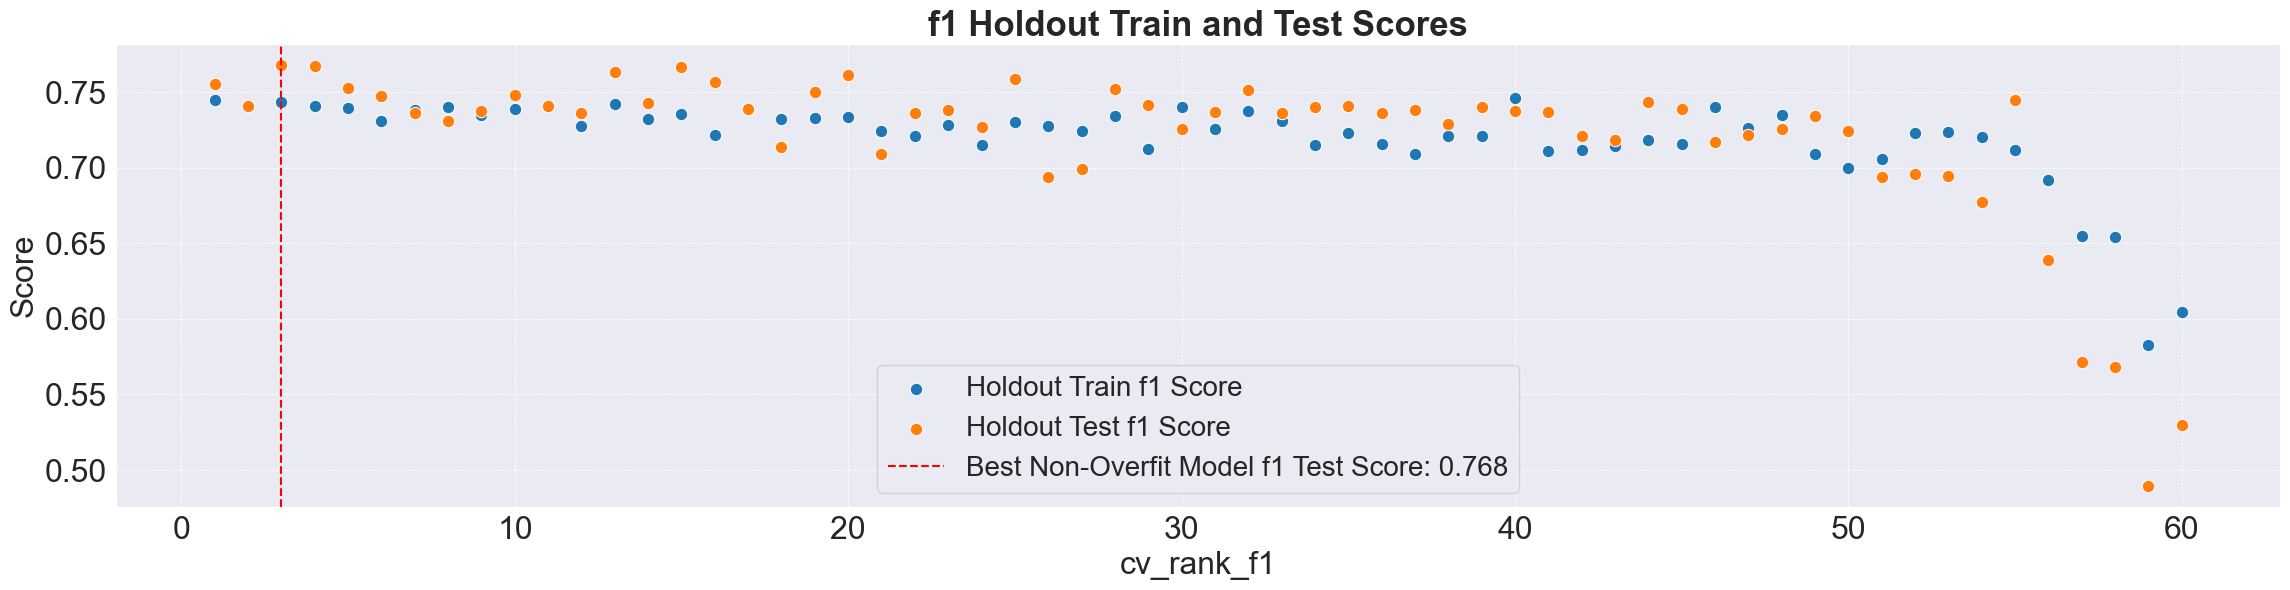

In [15]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),        
    poly_params={'transformer__num__poly__degree':[1,2]}, 
    num_cols=['neg_to_billed','offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),
                   
    scaler=('scaler', MinMaxScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(7e-7, 5e-5) }, 
    estimator_dicts = [{
        'est_tuple': ('lgr', LogisticRegression(verbose=0, fit_intercept=True, random_state=rs, n_jobs=-1)), 
        'est_params': {
            'penalty': ['l2'],
            'C': loguniform(7e-2, 9e1), 
            'solver': ['newton-cholesky'], 
            'max_iter': [5000], 
            'class_weight': class_weights,
            'tol': loguniform(7e-7, 1e-4),
        }, },], set_name= 'ht_lgr_set5',         
    cv=5, n_iter=60, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

#### Set 6 - Try TargetEncoder again but with smoothing

Fitting 5 folds for each of 80 candidates, totalling 400 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__cat__rest_encoder__smooth,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.726750,No,0.732753,0.752556,1.661052,0.660585,1.160490,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000001,191,0.400000,0.000006,0.007500,33.366667,2,if_binary,35
2,0.725729,No,0.732566,0.744856,1.870361,0.662975,0.515406,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000026,270,0.475000,0.000031,0.007500,0.100000,2,if_binary,34
3,0.725483,Yes,0.735294,0.725000,0.669649,0.656510,3.060533,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000067,286,0.475000,0.000001,0.005000,44.455556,1,if_binary,37
4,0.723408,No,0.730423,0.744681,1.758988,0.678736,1.459034,"{'Accepted': 0.15645, 'Rejected': 1}",5000,l2,newton-cholesky,0.000004,265,0.450000,0.000002,0.002500,50.000000,2,if_binary,22


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__cat__rest_encoder__smooth,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
20,0.716547,No,0.737542,0.758621,1.686201,0.648979,31.003085,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,164,0.425,0.000038,0.0025,11.188889,2,if_binary,43,1
11,0.719784,No,0.732543,0.753507,1.657148,0.651261,15.811493,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,217,0.4,0.000001,0.005,16.733333,2,if_binary,40,2
26,0.715043,No,0.732018,0.753346,1.559827,0.625665,2.363757,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,240,0.425,0.00001,0,16.733333,2,if_binary,47,3
19,0.716584,No,0.733775,0.753036,1.569907,0.650870,28.161759,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000004,290,0.425,0.000002,0.0075,50.0,2,if_binary,41,4


<Figure size 640x480 with 0 Axes>

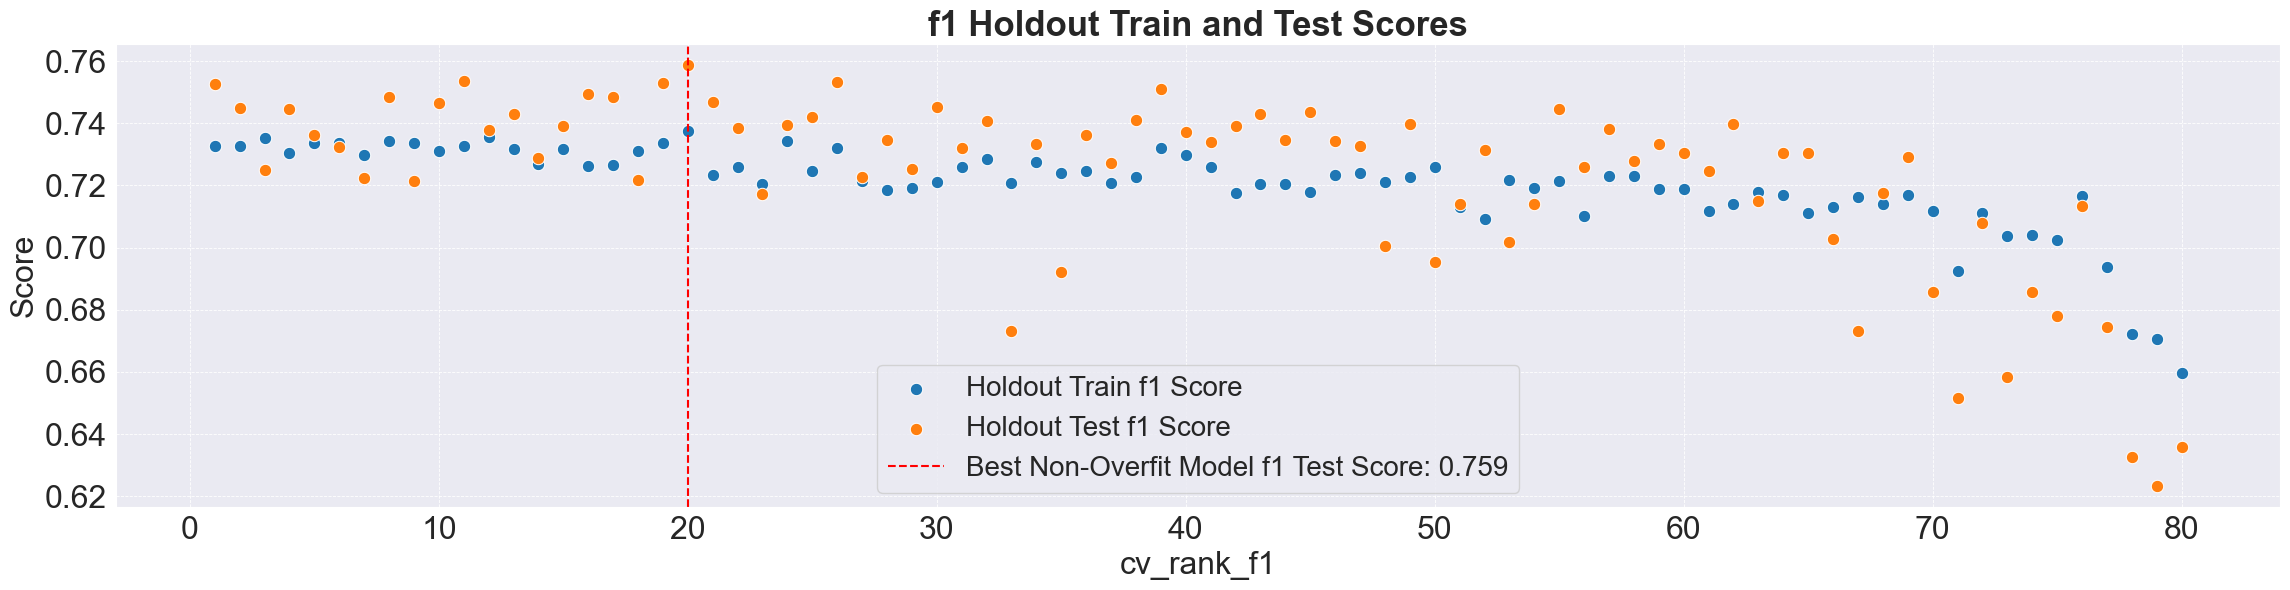

In [22]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),        
    poly_params={'transformer__num__poly__degree':[1,2]}, 
    num_cols=['neg_to_billed','offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075]},
    
    cat_encoder=('rest_encoder', TargetEncoder(target_type='binary', random_state=rs)),
    cat_encoder_params={'transformer__cat__rest_encoder__smooth': np.linspace(0.1,50, 10)},
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),
                   
    scaler=('scaler', MinMaxScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(7e-7, 5e-5) }, 
    estimator_dicts = [{
        'est_tuple': ('lgr', LogisticRegression(verbose=0, fit_intercept=True, random_state=rs, n_jobs=-1)), 
        'est_params': {
            'penalty': ['l2'],
            'C': loguniform(7e-2, 9e1), 
            'solver': ['newton-cholesky'], 
            'max_iter': [5000], 
            'class_weight': class_weights,
            'tol': loguniform(7e-7, 1e-4),
        }, },], set_name= 'ht_lgr_set6',         
    cv=5, n_iter=80, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

#### Set 7 Repeat Set 5 with StandardScaler

Fitting 5 folds for each of 60 candidates, totalling 300 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.735325,No,0.745308,0.768595,5.646847,0.673684,1.321411,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,152,0.450000,0.000014,0.007500,2,if_binary,17
2,0.727388,Yes,0.738399,0.729211,1.321539,0.669821,0.100680,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000004,231,0.425000,0.000001,0.005000,1,if_binary,20
3,0.726827,No,0.738629,0.761905,5.055099,0.667669,6.938525,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000073,243,0.475000,0.000008,0.007500,2,if_binary,21
4,0.726718,No,0.740845,0.758170,5.318229,0.689052,3.377054,"{'Accepted': 0.15645, 'Rejected': 1}",5000,l2,newton-cholesky,0.000003,283,0.425000,0.000046,0.007500,2,if_binary,13


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
1,0.735325,No,0.745308,0.768595,5.646847,0.673684,1.321411,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,152,0.45,0.000014,0.0075,2,if_binary,17,1
13,0.715429,No,0.737715,0.763209,7.346558,0.629733,0.43108,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,269,0.45,0.000003,0,2,if_binary,37,2
3,0.726827,No,0.738629,0.761905,5.055099,0.667669,6.938525,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000073,243,0.475,0.000008,0.0075,2,if_binary,21,3
22,0.711370,No,0.742741,0.761317,5.935090,0.660560,0.143197,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000051,239,0.45,0.000001,0.0025,2,if_binary,29,4


<Figure size 640x480 with 0 Axes>

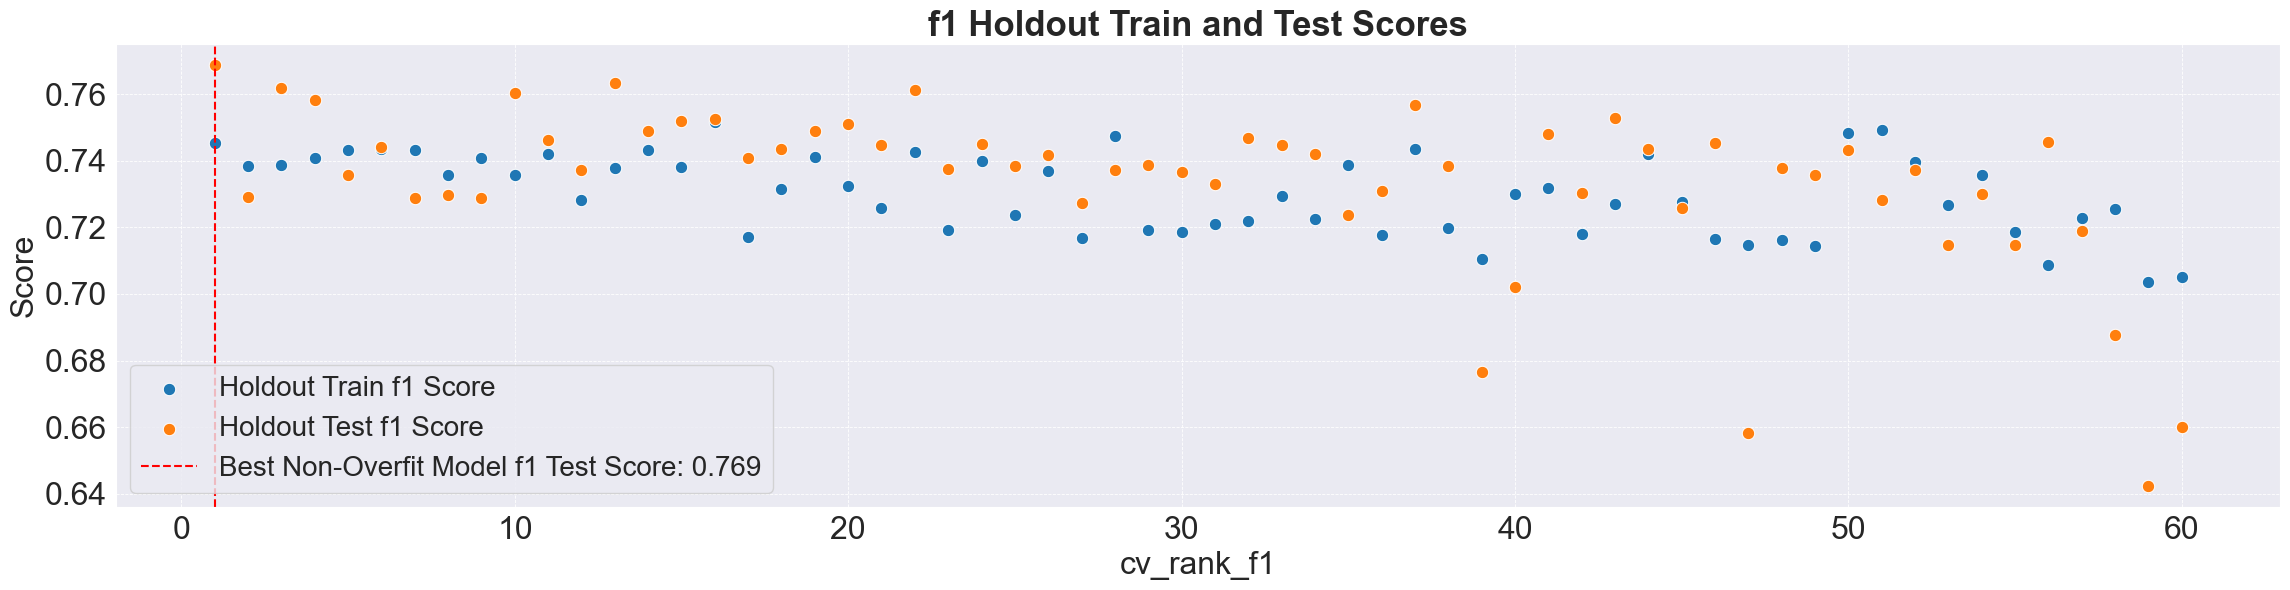

In [23]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),        
    poly_params={'transformer__num__poly__degree':[1,2]}, 
    num_cols=['neg_to_billed','offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),
                   
    scaler=('scaler', StandardScaler()), 
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(7e-7, 5e-5) }, 
    estimator_dicts = [{
        'est_tuple': ('lgr', LogisticRegression(verbose=0, fit_intercept=True, random_state=rs, n_jobs=-1)), 
        'est_params': {
            'penalty': ['l2'],
            'C': loguniform(7e-2, 9e1), 
            'solver': ['newton-cholesky'], 
            'max_iter': [5000], 
            'class_weight': class_weights,
            'tol': loguniform(7e-7, 1e-4),
        }, },], set_name= 'ht_lgr_set7',         
    cv=5, n_iter=60, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

#### Set 8- Repeat Set 5 with RobustScaler

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/basilhaddad/anaconda3/envs/snowflakes/lib/python3.11/site-packages/sklearn/feature_selection/_base.py:102: UserWarning:

No features were selected: either the data is too noisy or the selection test too strict.

/Users/basilhaddad/anaconda3/envs/snowflakes/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


1 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/basilhaddad/anaconda3/envs/snowflakes/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/basilhaddad/an

cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.728793,Yes,0.734859,0.731915,0.836505,0.666883,0.290358,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,275,0.450000,0.000020,0.005000,1,if_binary,23
2,0.727140,Yes,0.735043,0.724832,2.118734,0.701533,0.338734,"{'Accepted': 0.15645, 'Rejected': 1}",5000,l2,newton-cholesky,0.000009,286,0.475000,0.000011,0.007500,1,if_binary,11
3,0.724297,No,0.737694,0.766046,11.250380,0.663731,6.938525,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000073,243,0.475000,0.000008,0.007500,2,if_binary,24
4,0.723925,No,0.742662,0.750533,1.792306,0.663085,0.792849,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000023,270,0.475000,0.000031,0.007500,1,if_binary,25


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
15,0.716901,No,0.733591,0.775348,11.903133,0.635322,0.43108,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,269,0.45,0.000003,0,2,if_binary,35,1
9,0.720821,No,0.740891,0.771134,9.269115,0.661991,1.321411,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,152,0.45,0.000014,0.0075,2,if_binary,26,2
3,0.724297,No,0.737694,0.766046,11.250380,0.663731,6.938525,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000073,243,0.475,0.000008,0.0075,2,if_binary,24,3
8,0.720892,No,0.735219,0.764133,11.983479,0.629205,86.498776,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000024,172,0.5,0.000002,0.0075,2,if_binary,36,4


<Figure size 640x480 with 0 Axes>

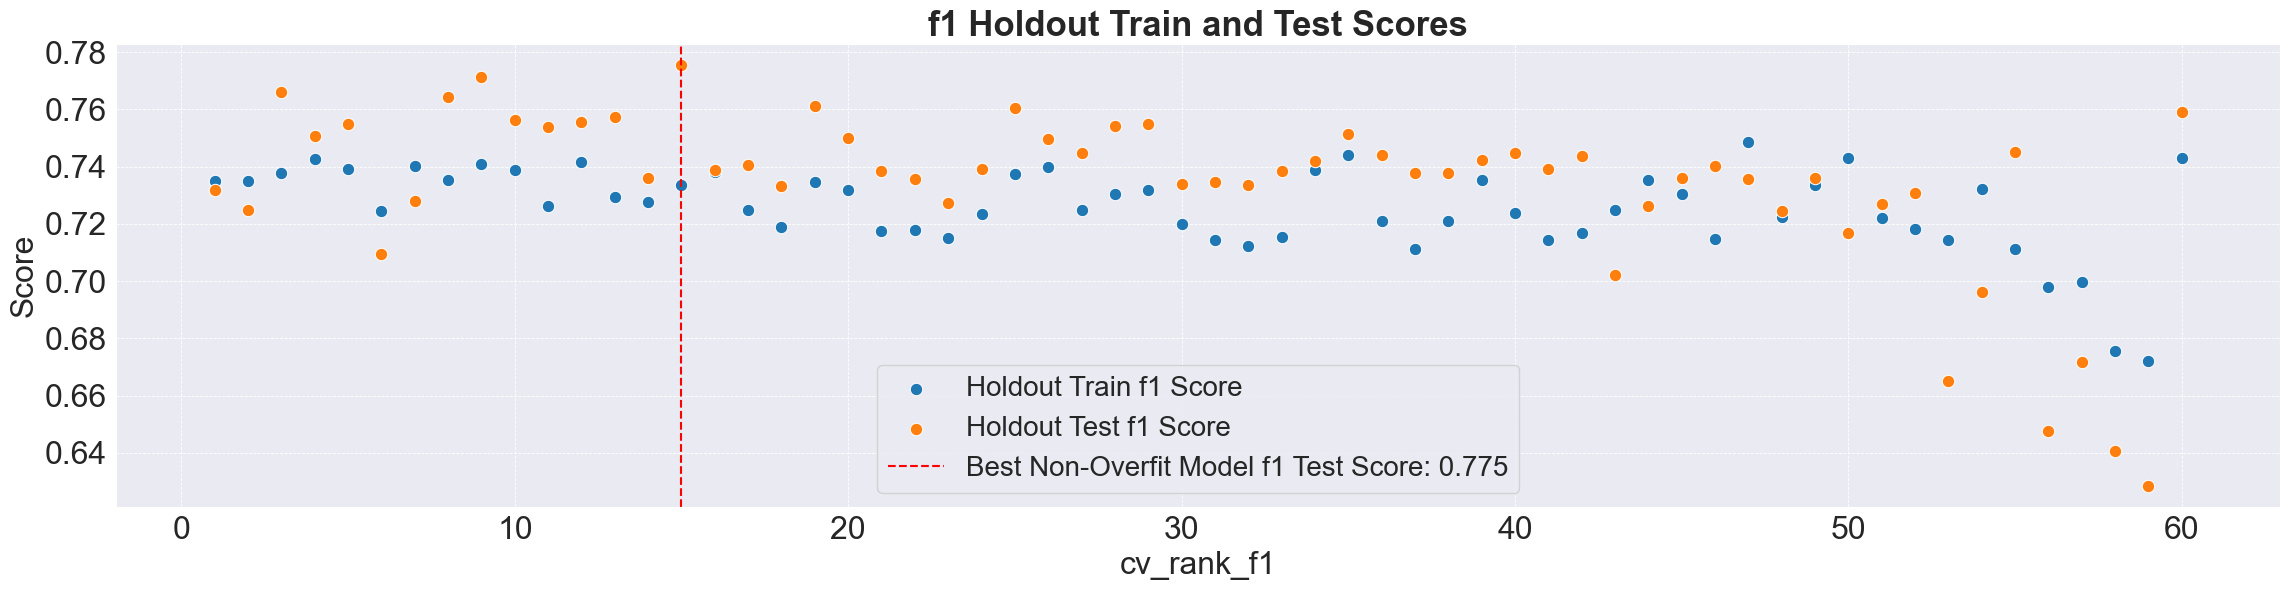

In [25]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),        
    poly_params={'transformer__num__poly__degree':[1,2]}, 
    num_cols=['neg_to_billed','offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),
                   
    scaler=('scaler', RobustScaler()), 
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(7e-7, 5e-5) }, 
    estimator_dicts = [{
        'est_tuple': ('lgr', LogisticRegression(verbose=0, fit_intercept=True, random_state=rs, n_jobs=-1)), 
        'est_params': {
            'penalty': ['l2'],
            'C': loguniform(7e-2, 9e1), 
            'solver': ['newton-cholesky'], 
            'max_iter': [5000], 
            'class_weight': class_weights,
            'tol': loguniform(7e-7, 1e-4),
        }, },], set_name= 'ht_lgr_set8',         
    cv=5, n_iter=60, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

Even though RobustScaler did slightly better in the holdout validation test, the cross-validation test results were considerably higher with StandardScaler which shows more reliability

#### Set 9 Restrict parameters from set 5, , add intermediary rare_to_values, increase range of k_neighbors in oversampler

Fitting 5 folds for each of 80 candidates, totalling 400 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision
1,0.730234,No,0.739071,0.757322,5.278206,0.672623,0.594625,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000004,255,0.500000,0.000034,0.007500,28
2,0.726668,No,0.739355,0.767123,4.754988,0.644485,0.135759,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000003,314,0.450000,0.000005,0.005000,45
3,0.725625,No,0.734375,0.759382,5.352406,0.685964,0.797396,"{'Accepted': 0.15645, 'Rejected': 1}",5000,l2,newton-cholesky,0.000008,193,0.425000,0.000045,0.007500,19
4,0.725443,No,0.751015,0.766393,4.775447,0.663439,17.706262,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000001,180,0.475000,0.000034,0.005000,34


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_lgr__C,param_lgr__class_weight,param_lgr__max_iter,param_lgr__penalty,param_lgr__solver,param_lgr__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision,holdout_rank_f1
12,0.718970,No,0.757640,0.772926,6.782122,0.684009,0.480371,"{'Accepted': 0.15645, 'Rejected': 1}",5000,l2,newton-cholesky,0.000007,299,0.475,0.000001,0.0035,21,1
11,0.719417,No,0.738421,0.767717,5.242745,0.630521,22.665666,"{'Accepted': 0.3129, 'Rejected': 1}",5000,l2,newton-cholesky,0.000002,144,0.475,0.000031,0.005,50,2
20,0.716603,No,0.745283,0.767635,5.905164,0.664826,0.112679,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.00001,220,0.425,0.000004,0.0025,32,3
60,0.697517,No,0.740537,0.767296,6.144213,0.652462,1.480274,"{'Accepted': 0.2086, 'Rejected': 1}",5000,l2,newton-cholesky,0.000011,191,0.5,0.000053,0.0025,43,4


<Figure size 640x480 with 0 Axes>

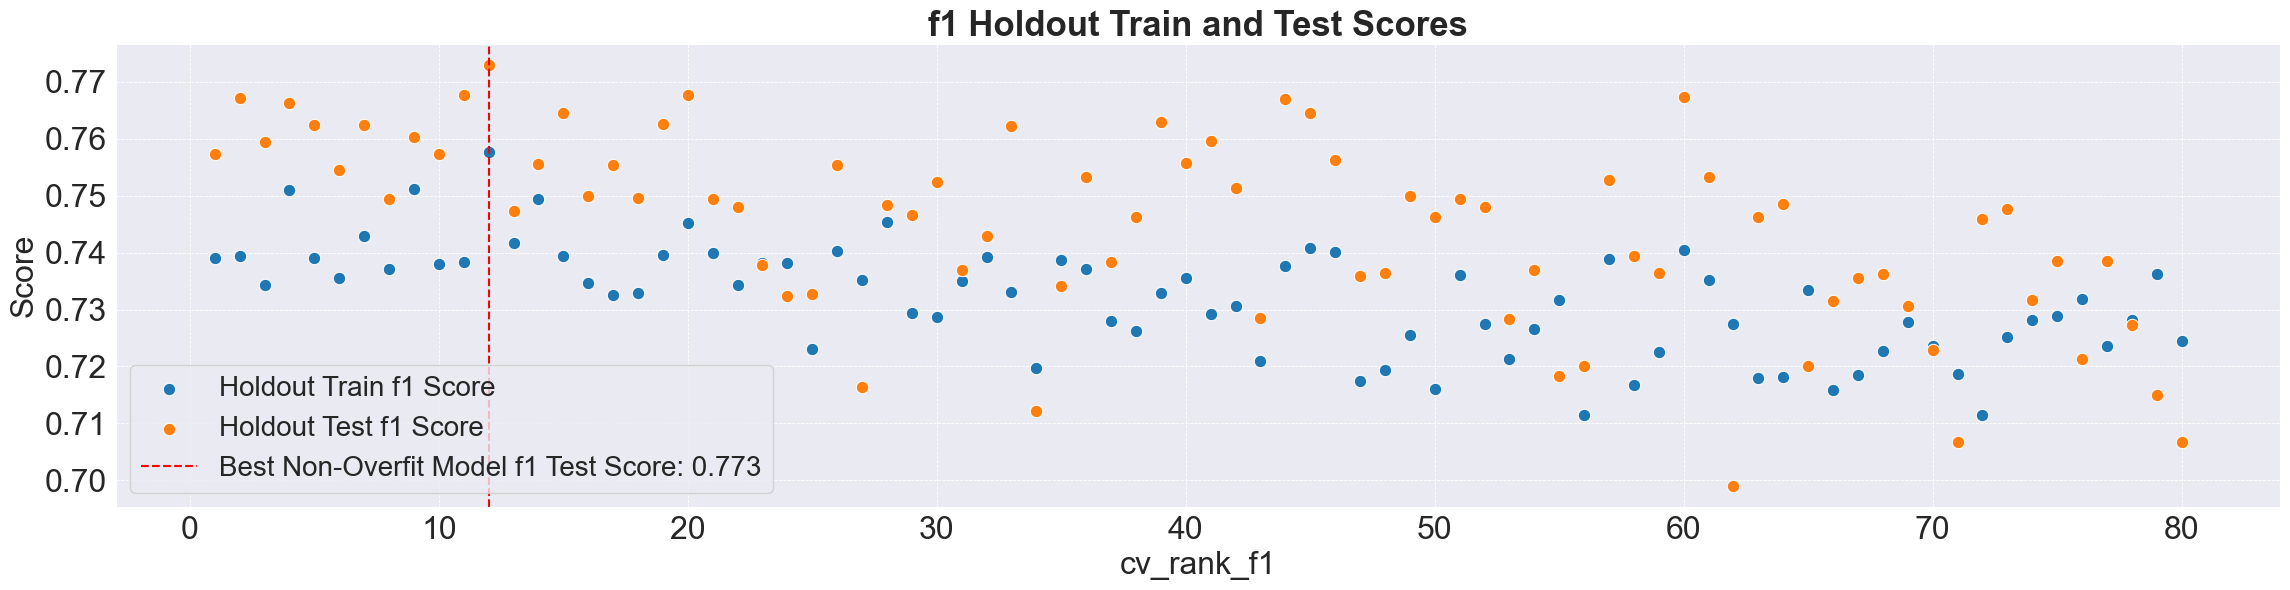

In [26]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(degree=2, include_bias=False)),        
    num_cols=['neg_to_billed','offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.0035, 0.005, 0.0065, 0.0075]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder(drop='if_binary'))),
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 321)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),
                   
    scaler=('scaler', StandardScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 6e-5) }, 
    estimator_dicts = [{
        'est_tuple': ('lgr', LogisticRegression(verbose=0, fit_intercept=True, random_state=rs, n_jobs=-1)), 
        'est_params': {
            'penalty': ['l2'],
            'C': loguniform(1e-1, 7e1), 
            'solver': ['newton-cholesky'], 
            'max_iter': [5000], 
            'class_weight': class_weights,
            'tol': loguniform(7e-7, 5e-5),
        }, },], set_name= 'ht_lgr_set9',         
    cv=5, n_iter=80, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

In [37]:
best_lgr = load('models/hyperparam_tuning/ht_lgr_set9.joblib')

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


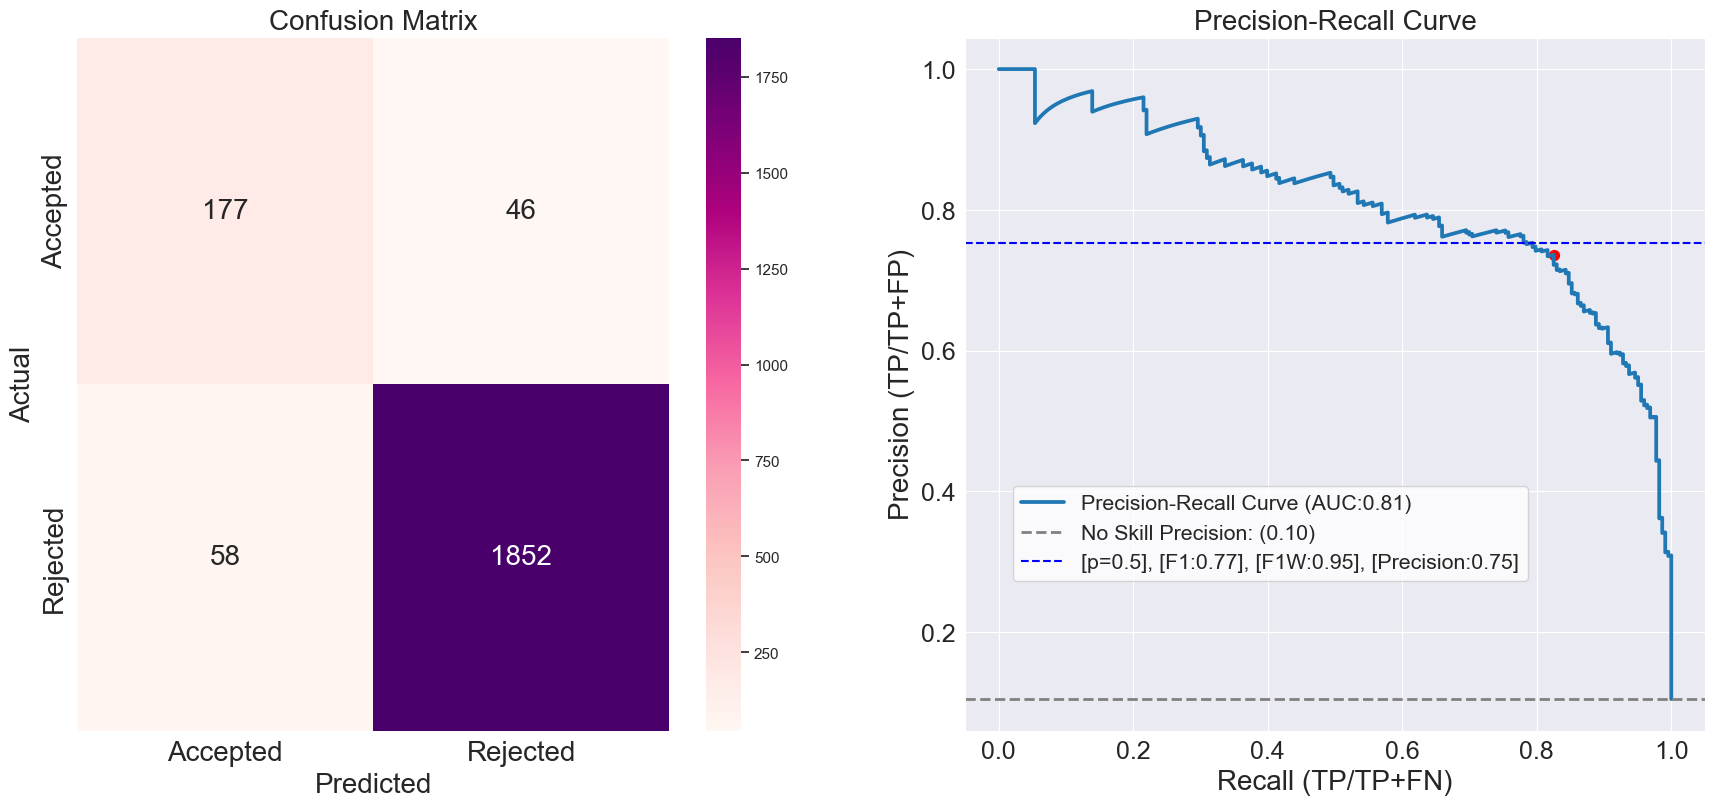

In [38]:
myreload()
plot.conf_matrix_PRC(best_lgr, X_test, y_test, probas_pos_index=0, threshold=0.5,
                     common_fontsize=20, figx=21, figy=9, xlegend=0.05, ylegend=0.2) 

### RandomForest and GradientBoosting 
#### Set 1: Simple imputer, yeo-johnson, polynomial features, category combiner, oversampler/undersampler

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.
Fitting 5 folds for each of 60 candidates, totalling 300 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_over__k_neighbors,param_over__sampling_strategy,param_rf__bootstrap,param_rf__class_weight,param_rf__criterion,param_rf__max_depth,param_rf__max_features,param_rf__max_samples,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,param_rf__oob_score,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.704874,No,0.711527,0.716522,1.089907,0.577891,168,0.500000,True,balanced_subsample,entropy,4,log2,0.399417,35,0.008750,244,False,20,-inf,0,1,if_binary,3
2,0.702424,No,0.709371,0.724689,1.904556,0.579802,284,0.500000,True,balanced_subsample,entropy,4,log2,0.660775,40,0.005000,382,False,23,-inf,0.002500,1,if_binary,1
3,0.701619,No,0.710024,0.725979,1.613036,0.579259,242,0.475000,True,balanced_subsample,gini,4,sqrt,0.723753,55,0.006250,314,False,24,-inf,0.003500,1,if_binary,2
4,0.701276,No,0.715789,0.719023,0.671864,0.574977,166,0.400000,True,balanced_subsample,log_loss,4,log2,0.120335,55,0.007500,162,False,20,-inf,0,1,if_binary,6


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_over__k_neighbors,param_over__sampling_strategy,param_rf__bootstrap,param_rf__class_weight,param_rf__criterion,param_rf__max_depth,param_rf__max_features,param_rf__max_samples,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,param_rf__oob_score,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
22,0.693198,No,0.706651,0.728546,2.204137,0.564087,225,0.475,True,balanced_subsample,entropy,3,sqrt,0.336507,55,0.00875,127,False,25,-inf,0.005,2,if_binary,21,1
3,0.701619,No,0.710024,0.725979,1.613036,0.579259,242,0.475,True,balanced_subsample,gini,4,sqrt,0.723753,55,0.00625,314,False,24,-inf,0.0035,1,if_binary,2,2
21,0.693224,No,0.710744,0.725352,1.328660,0.567895,229,0.45,True,balanced_subsample,log_loss,4,log2,0.616138,50,0.005,227,False,20,-inf,0.0025,1,if_binary,11,3
33,0.689746,No,0.709069,0.725352,1.884933,0.560271,208,0.4,True,balanced_subsample,entropy,3,log2,0.662926,50,0.00625,440,False,20,-inf,0.005,1,if_binary,28,4


<Figure size 640x480 with 0 Axes>

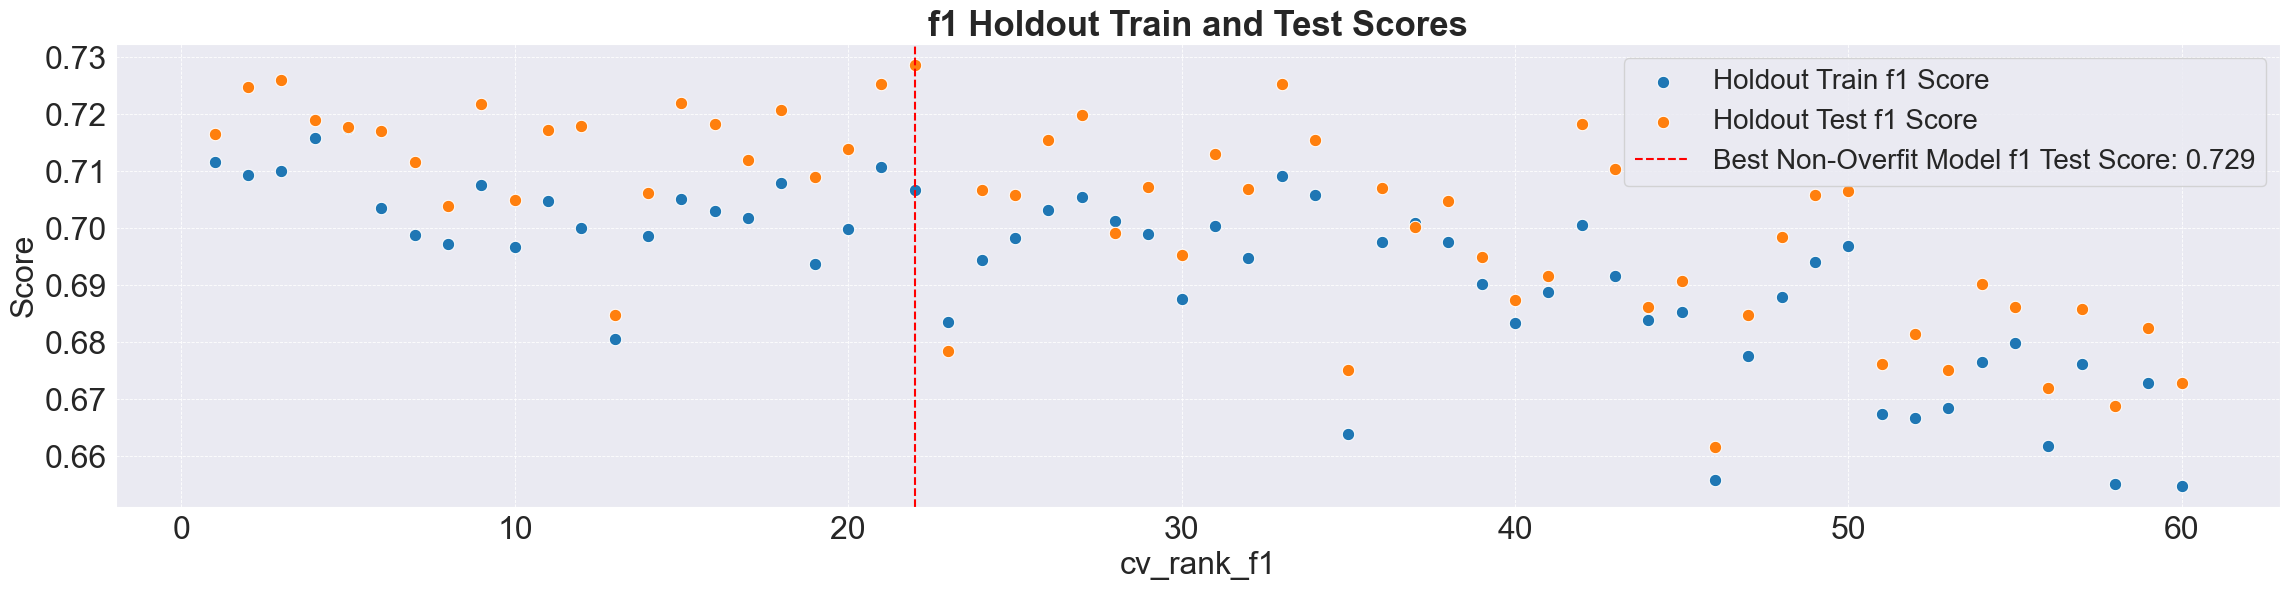

Fitting 5 folds for each of 60 candidates, totalling 300 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_gbc__criterion,param_gbc__learning_rate,param_gbc__loss,param_gbc__max_depth,param_gbc__max_features,param_gbc__min_samples_leaf,param_gbc__min_samples_split,param_gbc__n_estimators,param_gbc__subsample,param_over__k_neighbors,param_over__sampling_strategy,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.712458,Yes,0.725118,0.721254,2.133251,0.596743,squared_error,0.010000,log_loss,4,sqrt,35,0.008750,400,0.900000,290,0.500000,24,-inf,0.007500,1,if_binary,3
2,0.712273,Yes,0.732477,0.715503,1.733286,0.598570,squared_error,0.100000,log_loss,2,sqrt,50,0.007500,600,0.500000,300,0.500000,17,-inf,0.007500,1,if_binary,2
3,0.710038,Yes,0.863281,0.719101,3.480732,0.614202,friedman_mse,0.100000,log_loss,4,log2,50,0.005000,800,0.820000,221,0.500000,21,-inf,0.002500,1,if_binary,1
4,0.709773,Yes,0.733179,0.703448,11.567157,0.592315,squared_error,0.010000,log_loss,4,log2,50,0.007500,1000,0.820000,208,0.450000,25,-inf,0,3,if_binary,7


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_gbc__criterion,param_gbc__learning_rate,param_gbc__loss,param_gbc__max_depth,param_gbc__max_features,param_gbc__min_samples_leaf,param_gbc__min_samples_split,param_gbc__n_estimators,param_gbc__subsample,param_over__k_neighbors,param_over__sampling_strategy,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
5,0.709451,No,0.733373,0.741935,1.069937,0.595956,squared_error,0.1,log_loss,2,log2,45,0.00625,200,0.82,168,0.5,19,-inf,0.0035,1,if_binary,4,1
9,0.706279,No,0.729825,0.731369,3.443794,0.595293,friedman_mse,0.01,log_loss,4,log2,50,0.005,1000,0.58,284,0.5,19,-inf,0.01,1,if_binary,5,2
38,0.694530,No,0.709602,0.725352,2.470741,0.564831,squared_error,0.01,log_loss,2,sqrt,45,0.005,500,0.5,190,0.425,25,-inf,0.0035,2,if_binary,46,3
33,0.696271,No,0.708643,0.723260,3.664634,0.570986,squared_error,0.01,log_loss,3,log2,55,0.01,700,0.5,238,0.45,16,-inf,0.005,2,if_binary,35,4


<Figure size 640x480 with 0 Axes>

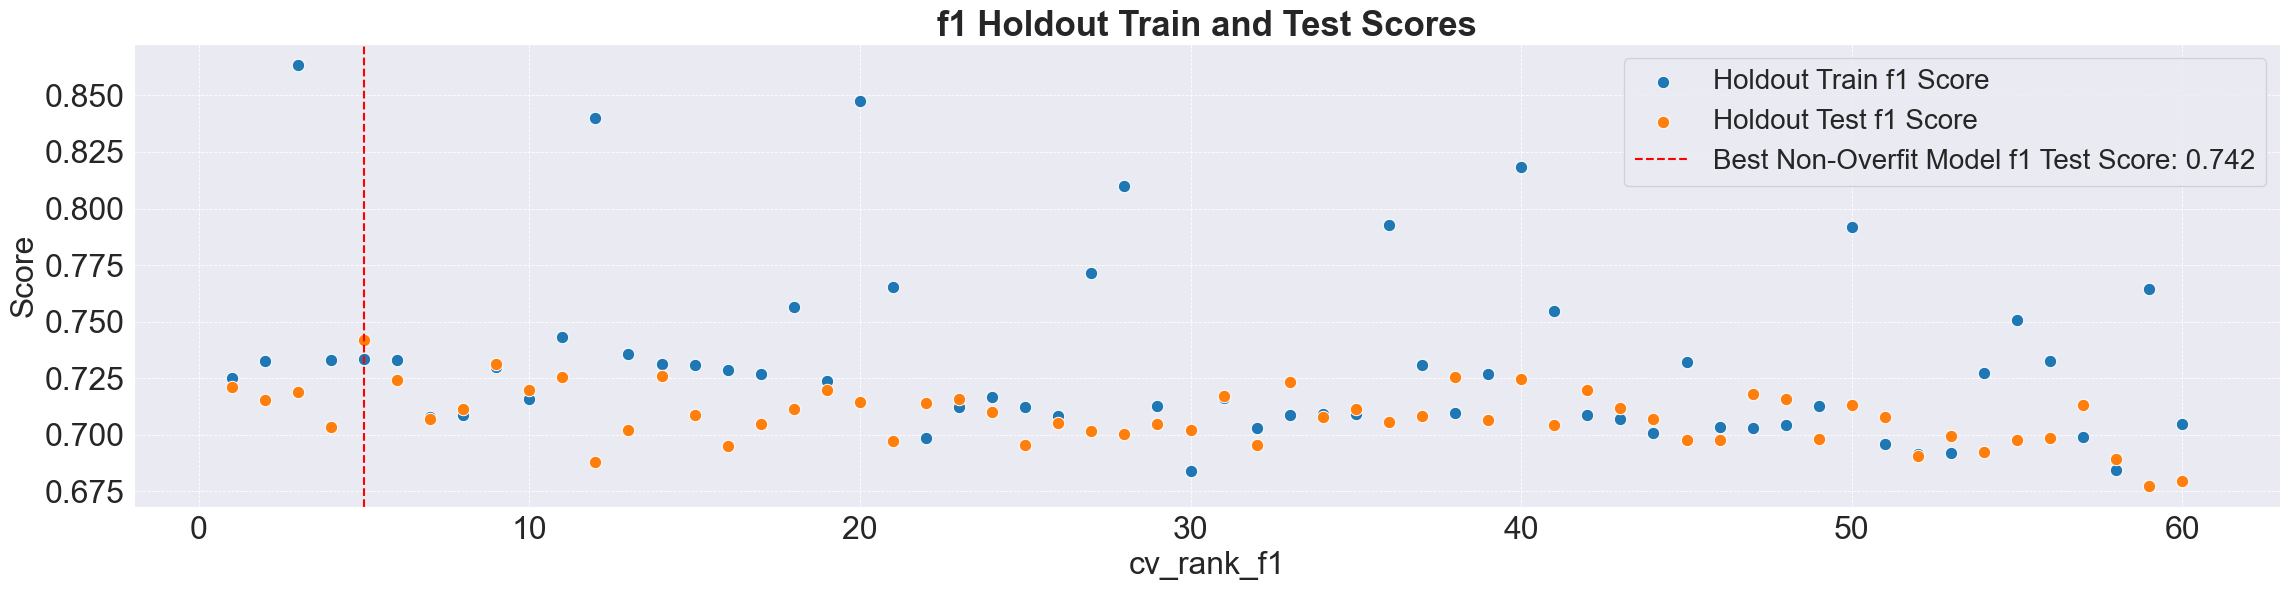

model,train f1 score,test f1 score,mean fit time,mean_test_precision
rf,0.706651,0.728546,2.204137,0.564087
gbc,0.733373,0.741935,1.069937,0.595956


In [27]:
myreload()
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),poly_params={'transformer__num__poly__degree':[1,2,3]},        
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.0035, 0.005, 0.0075, 0.01]},
    
    cat_encoder=('rest_encoder', TargetEncoder(target_type='binary', random_state=rs)),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),
                   
    scaler=('scaler', MinMaxScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': [-np.inf], 'selector__max_features': randint(14,27)}, 
    
    estimator_dicts = [{
        'est_tuple': ('rf', RandomForestClassifier(random_state=rs, n_jobs=-1)),
        'est_params': {
            'n_estimators': randint(100,500),
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': randint(2, 5), #start with no limit
            'min_samples_split': np.linspace(0.005, 0.01, 5), #usually 0.5% to 1%  min # samples required to split an internal node | overfit at lower
            'min_samples_leaf': range(35,60,5), #min samples required to be a leaf node | overfit at lower values |     
            'max_features': ['sqrt', 'log2'],
            'class_weight': ['balanced_subsample'], #RF benefits from balanced_subsample for imbalanced datasets
            'bootstrap': [True],'oob_score': [False], 
            'max_samples': uniform(0.1,0.8),
        }
    },
    {
        'est_tuple': ('gbc', GradientBoostingClassifier(verbose=0, random_state=rs)), 
        'est_params': {
            'loss': ['log_loss'], #Generaly default works wells #'exponential', 
            'learning_rate': [0.01, 0.1], #0.1 good starting point. 
            'n_estimators': range(100,1001,100), 
            #Most important tree parameters first 
            'max_depth': range(2,5,1), #**range(4, 8), #normally 5-8 (8 for large datasets)
            'min_samples_split': np.linspace(0.005, 0.01, 5), #usually 0.5% to 1% 
            #Fine Tuning 
            'min_samples_leaf': range(35,60,5), #smaller for imbalanced dataset
            'max_features': ['sqrt', 'log2'], 
            'subsample':np.linspace(0.5, 0.9, 6), #Stochastic sample size
            'criterion': ['friedman_mse', 'squared_error'], 
        }},], 
    set_name= 'ht_ens_set1', cv=5, n_iter=60, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

In [29]:
#Define Primary and Secondary Scoring Metrics as established in EDA
cb_scoring_metrics = {
    'f1': make_scorer(f1_score, average='binary', pos_label=1, zero_division=0.0),
    'precision': make_scorer(precision_score, average='binary', pos_label=1, zero_division=0.0)}

#### Set 2: Use CatBoostEncoder, wide range of parameters

Fitting 5 folds for each of 80 candidates, totalling 400 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_over__k_neighbors,param_over__sampling_strategy,param_rf__bootstrap,param_rf__class_weight,param_rf__criterion,param_rf__max_depth,param_rf__max_features,param_rf__max_samples,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,param_rf__oob_score,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__cat__rest_encoder__a,param_transformer__cat__rest_encoder__sigma,param_transformer__num__poly__degree,rank_test_precision
1,0.715174,No,0.712507,0.716522,2.388269,0.599129,168,0.475000,True,balanced_subsample,gini,4,sqrt,0.577853,55,0.008750,552,False,34,-inf,0.010000,1,0.200000,1,1
2,0.713870,Yes,0.722488,0.714789,1.937184,0.594605,220,0.500000,True,balanced_subsample,gini,5,log2,0.731647,35,0.005000,439,False,30,-inf,0,1,0.200000,1,2
3,0.711182,No,0.712848,0.717504,1.991284,0.591702,225,0.425000,True,balanced_subsample,log_loss,4,log2,0.719343,30,0.005000,492,False,33,-inf,0.002500,1.200000,0.300000,1,6
4,0.710894,No,0.711584,0.715026,2.019653,0.591180,286,0.475000,True,balanced_subsample,gini,3,sqrt,0.657350,55,0.005000,472,False,28,-inf,0.002500,1.100000,0.300000,1,7


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_over__k_neighbors,param_over__sampling_strategy,param_rf__bootstrap,param_rf__class_weight,param_rf__criterion,param_rf__max_depth,param_rf__max_features,param_rf__max_samples,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,param_rf__oob_score,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__cat__rest_encoder__a,param_transformer__cat__rest_encoder__sigma,param_transformer__num__poly__degree,rank_test_precision,holdout_rank_f1
21,0.705155,No,0.714628,0.720280,1.166803,0.585595,246,0.475,True,balanced_subsample,gini,3,log2,0.588537,40,0.005,218,False,27,-inf,0.01,1,0.3,1,14,1
9,0.708712,No,0.710764,0.718310,2.166713,0.589333,198,0.45,True,balanced_subsample,gini,2,sqrt,0.617173,40,0.005,504,False,29,-inf,0.0025,1.2,0.1,1,8,2
3,0.711182,No,0.712848,0.717504,1.991284,0.591702,225,0.425,True,balanced_subsample,log_loss,4,log2,0.719343,30,0.005,492,False,33,-inf,0.0025,1.2,0.3,1,6,3
1,0.715174,No,0.712507,0.716522,2.388269,0.599129,168,0.475,True,balanced_subsample,gini,4,sqrt,0.577853,55,0.00875,552,False,34,-inf,0.01,1,0.2,1,1,4


<Figure size 640x480 with 0 Axes>

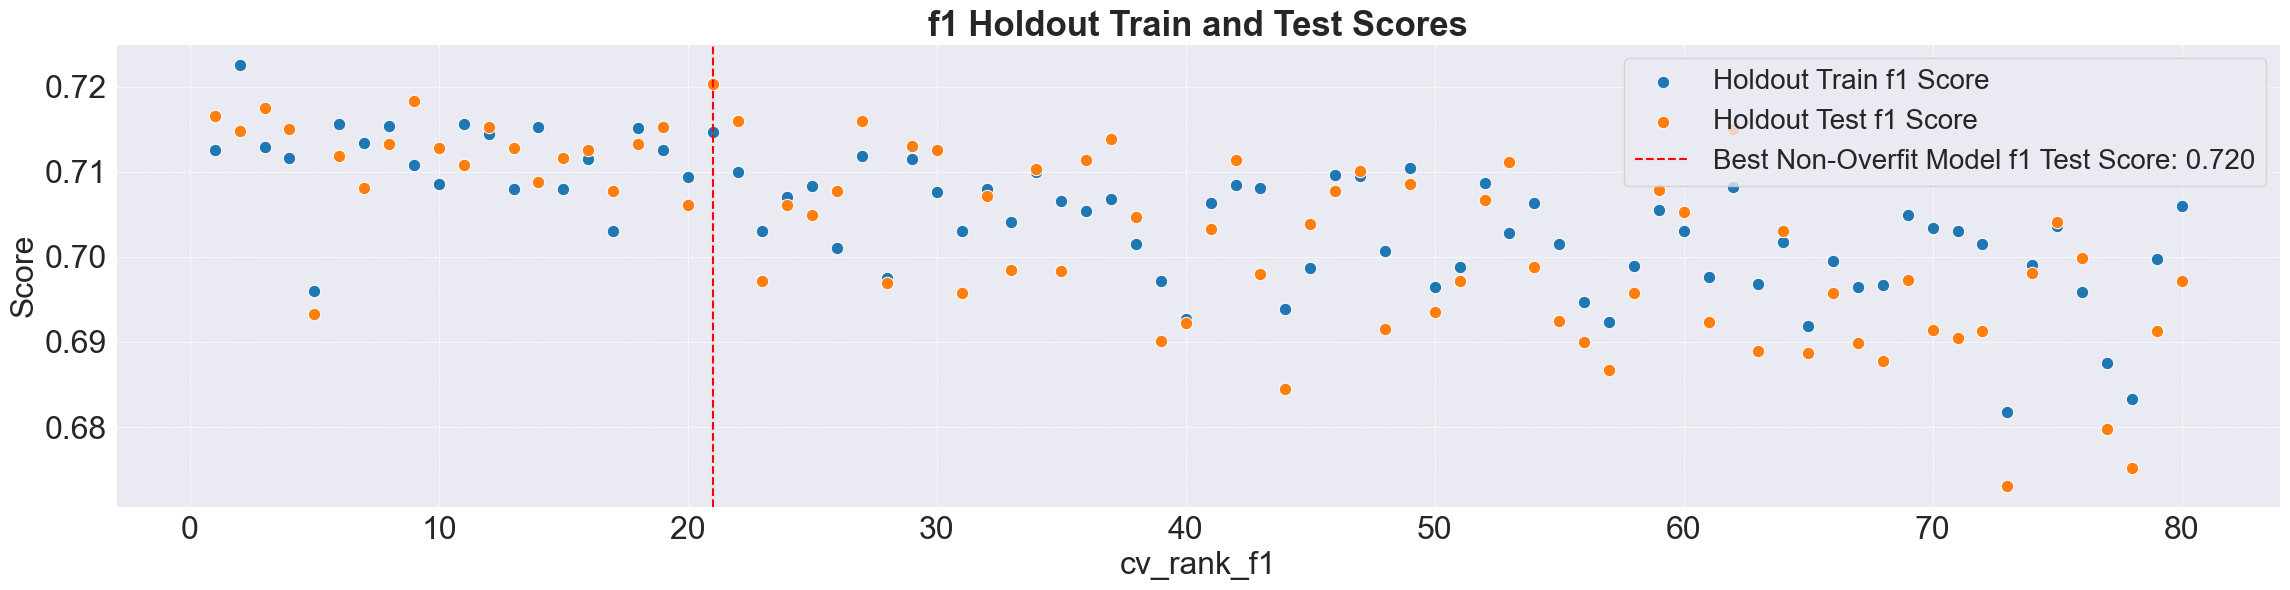

Fitting 5 folds for each of 80 candidates, totalling 400 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_gbc__criterion,param_gbc__learning_rate,param_gbc__loss,param_gbc__max_depth,param_gbc__max_features,param_gbc__min_samples_leaf,param_gbc__min_samples_split,param_gbc__n_estimators,param_gbc__subsample,param_over__k_neighbors,param_over__sampling_strategy,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__cat__rest_encoder__a,param_transformer__cat__rest_encoder__sigma,param_transformer__num__poly__degree,rank_test_precision
1,0.727868,Yes,0.767241,0.728261,4.205584,0.625406,friedman_mse,0.010000,log_loss,5,sqrt,30,0.005000,900,0.800000,273,0.425000,34,-inf,0,1.200000,0.100000,1,7
2,0.727113,Yes,0.754462,0.731884,3.930396,0.623111,friedman_mse,0.010000,log_loss,4,log2,60,0.008750,1200,0.600000,267,0.425000,30,-inf,0,1.100000,0.100000,1,10
3,0.723883,Yes,0.853175,0.730097,10.241319,0.644777,squared_error,0.100000,log_loss,5,sqrt,45,0.005000,2000,0.650000,191,0.475000,29,-inf,0.002500,1.100000,0.100000,1,1
4,0.720740,Yes,0.730699,0.725979,4.141246,0.611335,squared_error,0.010000,log_loss,2,log2,35,0.005000,1600,0.600000,296,0.500000,23,-inf,0,1.100000,0.100000,1,19


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_gbc__criterion,param_gbc__learning_rate,param_gbc__loss,param_gbc__max_depth,param_gbc__max_features,param_gbc__min_samples_leaf,param_gbc__min_samples_split,param_gbc__n_estimators,param_gbc__subsample,param_over__k_neighbors,param_over__sampling_strategy,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__cat__rest_encoder__a,param_transformer__cat__rest_encoder__sigma,param_transformer__num__poly__degree,rank_test_precision,holdout_rank_f1
36,0.708361,No,0.718401,0.722222,2.624963,0.583310,squared_error,0.005,log_loss,5,sqrt,60,0.00875,500,0.65,171,0.45,31,-inf,0.0025,1.1,0.2,1,60,1
52,0.702532,No,0.719114,0.719449,15.899695,0.586524,squared_error,0.01,log_loss,2,sqrt,35,0.0075,1500,0.8,280,0.475,24,-inf,0,1.1,0.2,3,55,2
27,0.710836,No,0.711864,0.716263,3.292644,0.585314,squared_error,0.005,log_loss,2,sqrt,50,0.0075,1100,0.8,204,0.475,23,-inf,0.005,1.1,0.1,1,57,3
67,0.697134,No,0.713868,0.716263,16.601635,0.570791,friedman_mse,0.005,log_loss,5,log2,55,0.00625,400,0.75,197,0.5,34,-inf,0,0.9,0.3,3,75,4


<Figure size 640x480 with 0 Axes>

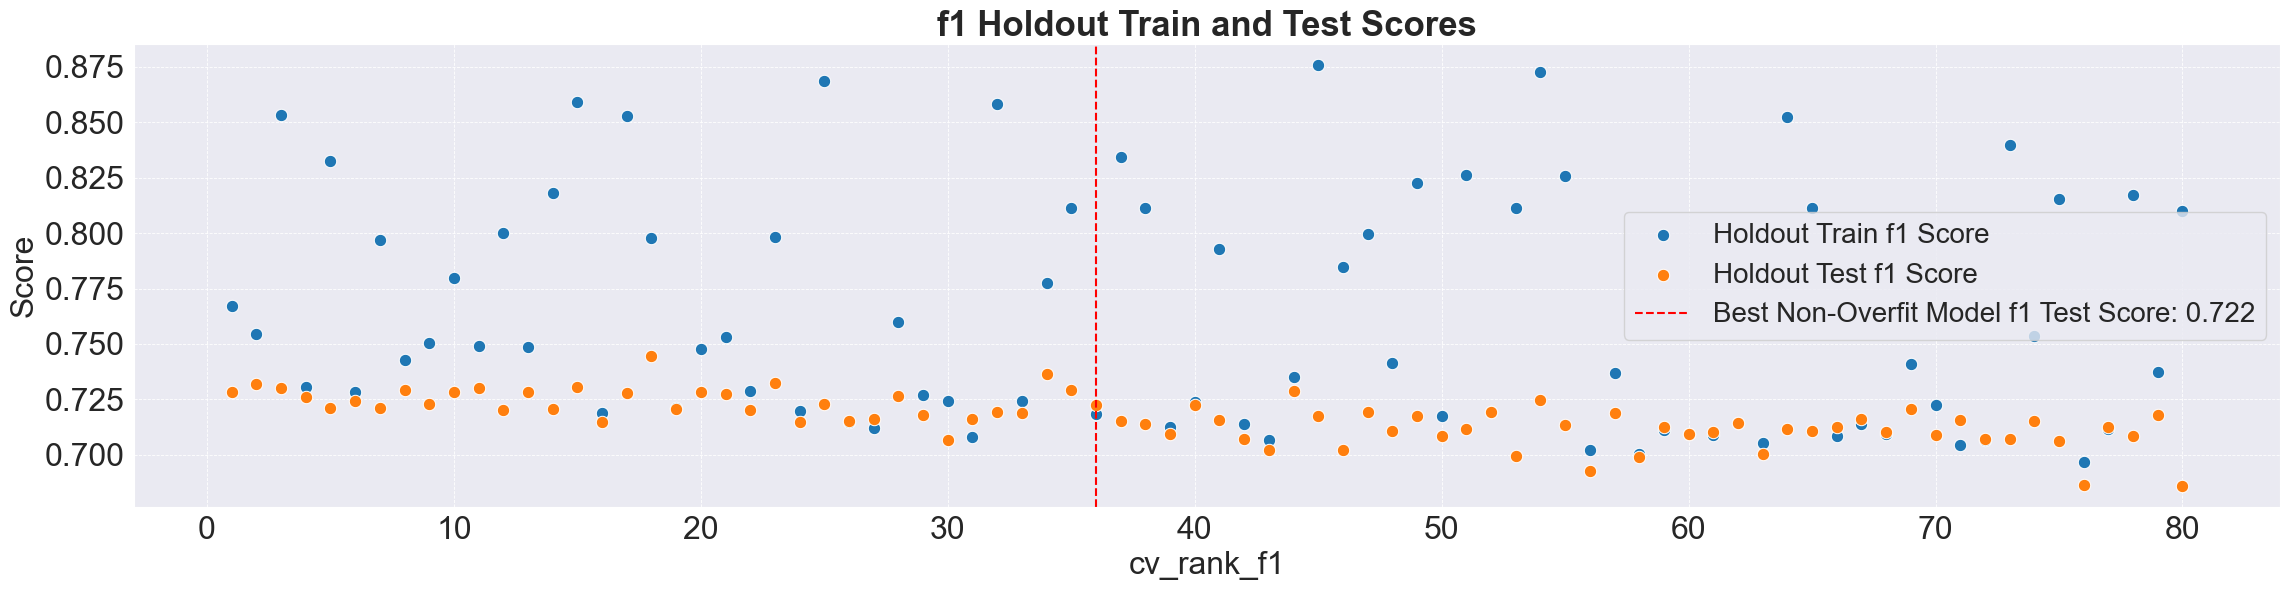

model,train f1 score,test f1 score,mean fit time,mean_test_precision
rf,0.714628,0.720280,1.166803,0.585595
gbc,0.718401,0.722222,2.624963,0.583310


In [30]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = cb_scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),poly_params={'transformer__num__poly__degree':[1,2,3]},           
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.01]}, #leave as is
    
    cat_encoder=('rest_encoder', CatBoostEncoder(random_state=rs)),
    cat_encoder_params={'transformer__cat__rest_encoder__a': [0.9, 1, 1.1, 1.2], 
                       'transformer__cat__rest_encoder__sigma': [0.1, 0.2, 0.3]}, 
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder(drop='if_binary'))),
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
    
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),
                       
    scaler=('scaler', MinMaxScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': [-np.inf], 'selector__max_features': randint(23,35)}, #last round 23-26
    estimator_dicts = [
                {
        'est_tuple': ('rf', RandomForestClassifier(random_state=rs, n_jobs=-1)),
        'est_params': {
            'n_estimators': randint(100,600), 
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [2,3,4,5], 
            'min_samples_split': np.linspace(0.005, 0.01, 5),
            'min_samples_leaf': range(30,61,5),     
            'max_features': ['sqrt', 'log2'], 
            'class_weight': ['balanced_subsample'], #RF benefits from balanced_subsample for imbalanced sets
            'bootstrap': [True], 'oob_score': [False], 
            'max_samples': uniform(0.5,0.25),
        }
    },
    {
        'est_tuple': ('gbc', GradientBoostingClassifier(verbose=0, random_state=rs)), 
        'est_params': {
            'loss': ['log_loss'], 
            'learning_rate': [0.001, 0.005, 0.01, 0.1],  
            'n_estimators': range(400,2001,100),
            #Most important tree parameters first 
            'max_depth': [2,3,4,5], 
            'min_samples_split': np.linspace(0.005, 0.01, 5), 
            #Fine Tuning 
            'min_samples_leaf': range(30,61,5), # #smaller for imbalanced dataset
            'max_features': ['sqrt', 'log2'],  
            'subsample': np.linspace(0.6, 0.85, 6),  #Stochastic sample size
            'criterion': ['friedman_mse', 'squared_error'], 
        }},], set_name= 'ht_ens_set2', cv=5, n_iter=80, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

#### Set 3: Removed RandomForest Model, Adjusted learning_rate, n_estimators with default CatBoostEncoder

Fitting 5 folds for each of 60 candidates, totalling 300 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_transformer__ohe__drop,param_transformer__num__poly__degree,param_transformer__cat__combiner__rare_to_value,param_gbc__subsample,param_gbc__n_estimators,param_gbc__min_samples_split,param_gbc__min_samples_leaf,param_gbc__max_features,param_gbc__max_depth,param_gbc__loss,param_gbc__learning_rate,param_gbc__criterion,rank_test_precision
1,0.732441,Yes,0.764706,0.754797,8.674058,0.719347,if_binary,1,0.005000,0.580000,1700,0.048000,60,sqrt,3,log_loss,0.005000,friedman_mse,39
2,0.729196,Yes,0.761429,0.748936,9.212308,0.717692,if_binary,1,0.002500,0.900000,1500,0.090000,30,sqrt,3,log_loss,0.005000,friedman_mse,42
3,0.727794,Yes,0.791192,0.768212,9.751244,0.738970,if_binary,1,0,0.820000,1600,0.048000,50,sqrt,5,log_loss,0.005000,friedman_mse,17
4,0.727209,Yes,0.757880,0.756410,8.896488,0.707141,if_binary,1,0.007500,0.660000,2300,0.069000,70,sqrt,2,log_loss,0.005000,friedman_mse,52


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_transformer__ohe__drop,param_transformer__num__poly__degree,param_transformer__cat__combiner__rare_to_value,param_gbc__subsample,param_gbc__n_estimators,param_gbc__min_samples_split,param_gbc__min_samples_leaf,param_gbc__max_features,param_gbc__max_depth,param_gbc__loss,param_gbc__learning_rate,param_gbc__criterion,rank_test_precision,holdout_rank_f1
18,0.715195,No,0.733691,0.740566,10.341518,0.736243,if_binary,1,0.0025,0.58,2700,0.006,50,sqrt,3,log_loss,0.001,friedman_mse,25,1
3,0.727794,Yes,0.791192,0.768212,9.751244,0.738970,if_binary,1,0,0.82,1600,0.048,50,sqrt,5,log_loss,0.005,friedman_mse,17,2
7,0.722546,Yes,0.780558,0.766595,13.412598,0.729396,if_binary,1,0.01,0.82,2900,0.09,50,log2,4,log_loss,0.005,friedman_mse,31,3
14,0.718037,Yes,0.795094,0.764579,10.333151,0.738771,if_binary,1,0.01,0.58,2400,0.09,50,log2,4,log_loss,0.01,friedman_mse,19,4


<Figure size 640x480 with 0 Axes>

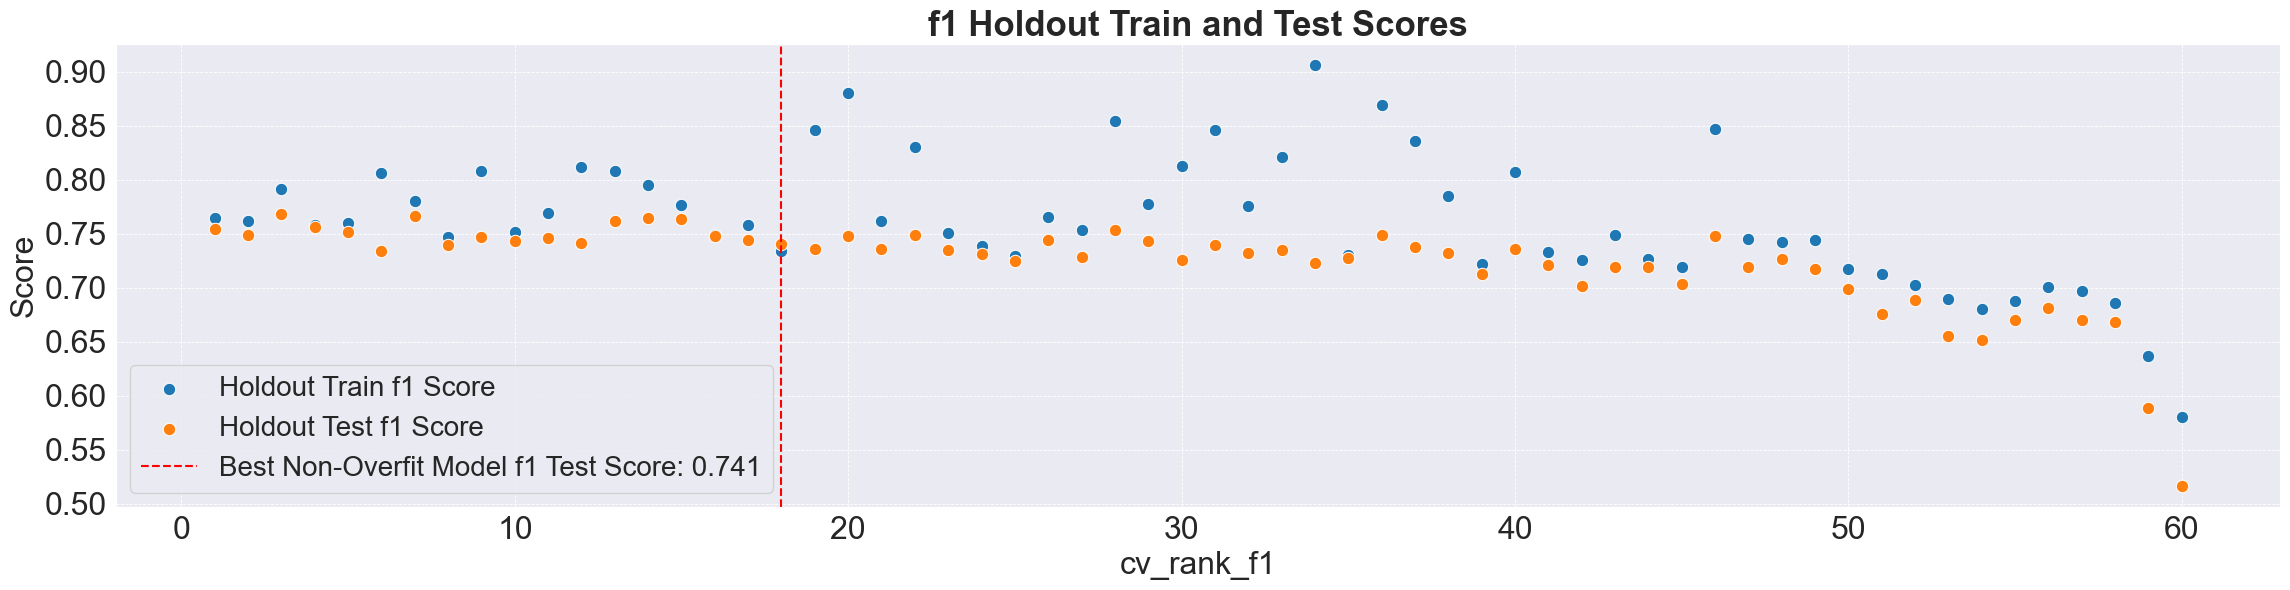

In [33]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = cb_scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),poly_params={'transformer__num__poly__degree':[1,2,3]},           
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075, 0.01]}, #leave as is
    
    cat_encoder=('rest_encoder', CatBoostEncoder(random_state=rs)),
    #cat_encoder_params={'transformer__cat__rest_encoder__a': [1,1.2,1.3,1.4], 
    #                   'transformer__cat__rest_encoder__sigma': [0.1, 0.2]}, 
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                   
    scaler=('scaler', RobustScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    estimator_dicts = [
    {
        'est_tuple': ('gbc', GradientBoostingClassifier(verbose=0, random_state=rs)), 
        'est_params': {
            'loss': ['log_loss'], #Generaly default works wells #'exponential'], 
            'learning_rate': [0.001, 0.005, 0.01], 
            'n_estimators': range(1500,3001,100),
            #Most important tree parameters first 
            'max_depth': [2,3,4,5], 
            'min_samples_split': np.linspace(0.006, 0.09, 5),
            #Fine Tuning 
            'min_samples_leaf': [30, 40, 50, 60, 70], 
            'max_features': ['sqrt', 'log2'],  
            'subsample': np.linspace(0.5, 0.9, 6),  #Stochastic sample size
            'criterion': ['friedman_mse'] 
        }},], set_name= 'ht_ens_set3', cv=5, n_iter=60, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

#### Set 4 - repeat Set 1 but with Binary Encoder

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.
Fitting 5 folds for each of 60 candidates, totalling 300 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_over__k_neighbors,param_over__sampling_strategy,param_rf__bootstrap,param_rf__class_weight,param_rf__criterion,param_rf__max_depth,param_rf__max_features,param_rf__max_samples,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,param_rf__oob_score,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.704314,No,0.708235,0.717770,1.075715,0.579722,282,0.400000,True,balanced_subsample,gini,3,log2,0.407361,35,0.007500,111,False,23,-inf,0.010000,1,if_binary,1
2,0.701629,No,0.704784,0.710801,2.165940,0.578536,242,0.475000,True,balanced_subsample,gini,4,sqrt,0.723753,55,0.006250,314,False,24,-inf,0.003500,1,if_binary,2
3,0.701241,No,0.706020,0.717770,1.398685,0.574283,142,0.450000,True,balanced_subsample,gini,3,sqrt,0.653949,40,0.008750,251,False,24,-inf,0.010000,1,if_binary,4
4,0.700597,No,0.705061,0.715278,2.027256,0.575221,284,0.500000,True,balanced_subsample,entropy,4,log2,0.660775,40,0.005000,382,False,23,-inf,0.002500,1,if_binary,3


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_over__k_neighbors,param_over__sampling_strategy,param_rf__bootstrap,param_rf__class_weight,param_rf__criterion,param_rf__max_depth,param_rf__max_features,param_rf__max_samples,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,param_rf__oob_score,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
19,0.692681,No,0.705678,0.717949,2.328135,0.562828,225,0.475,True,balanced_subsample,entropy,3,sqrt,0.336507,55,0.00875,127,False,25,-inf,0.005,2,if_binary,16,1
34,0.688496,No,0.702263,0.717949,1.450275,0.556213,286,0.4,True,balanced_subsample,log_loss,4,log2,0.695234,40,0.01,216,False,20,-inf,0,1,if_binary,32,2
1,0.704314,No,0.708235,0.717770,1.075715,0.579722,282,0.4,True,balanced_subsample,gini,3,log2,0.407361,35,0.0075,111,False,23,-inf,0.01,1,if_binary,1,3
3,0.701241,No,0.706020,0.717770,1.398685,0.574283,142,0.45,True,balanced_subsample,gini,3,sqrt,0.653949,40,0.00875,251,False,24,-inf,0.01,1,if_binary,4,4


<Figure size 640x480 with 0 Axes>

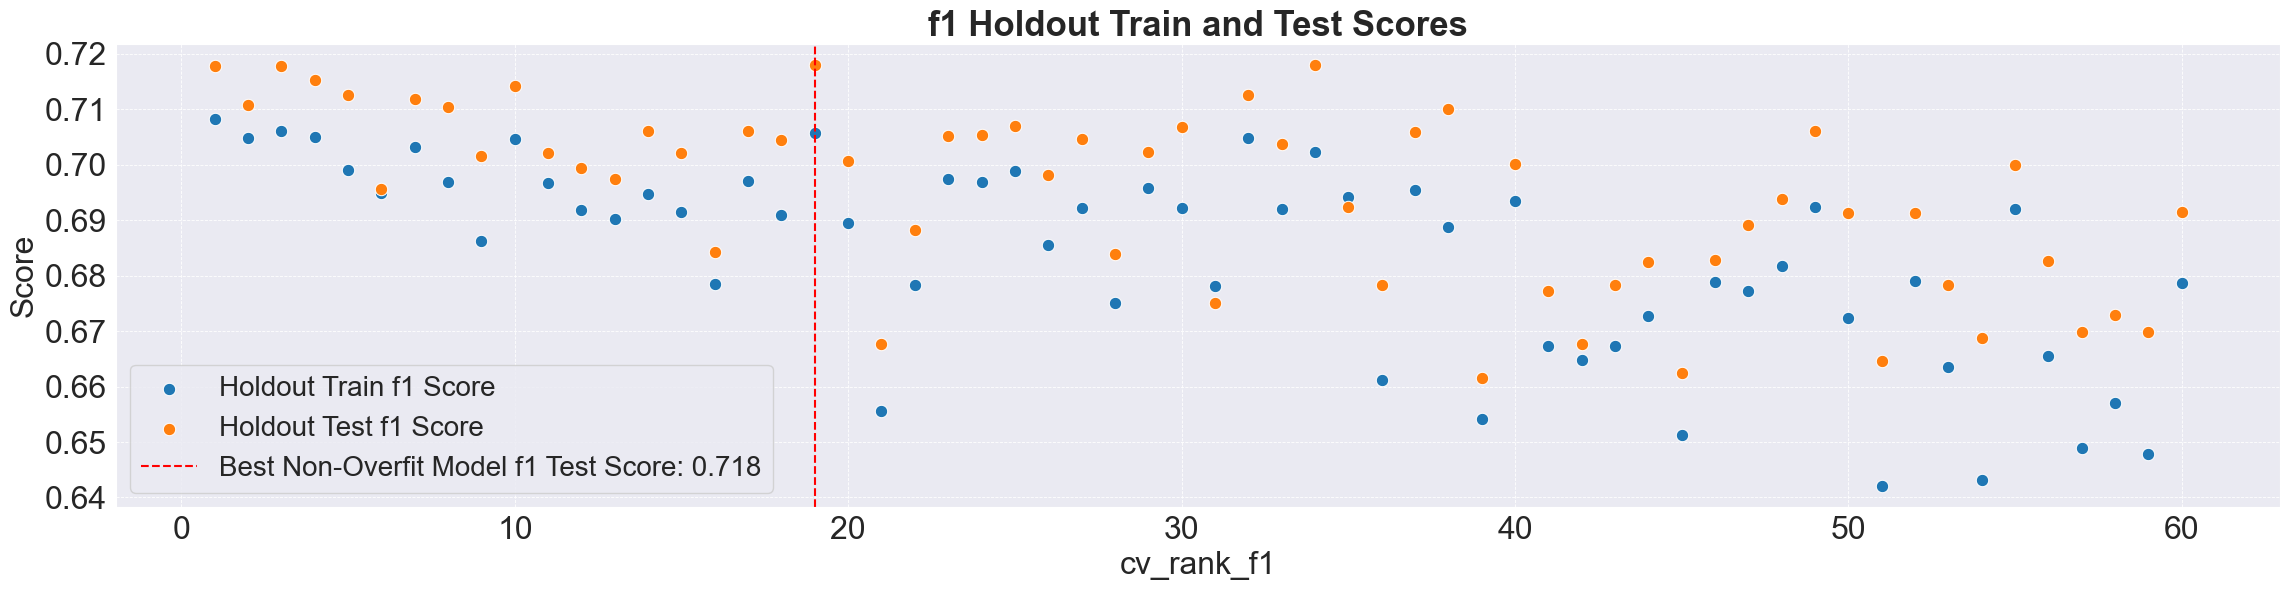

Fitting 5 folds for each of 60 candidates, totalling 300 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_gbc__criterion,param_gbc__learning_rate,param_gbc__loss,param_gbc__max_depth,param_gbc__max_features,param_gbc__min_samples_leaf,param_gbc__min_samples_split,param_gbc__n_estimators,param_gbc__subsample,param_over__k_neighbors,param_over__sampling_strategy,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision
1,0.718655,Yes,0.773779,0.738462,1.933220,0.630178,squared_error,0.100000,log_loss,2,sqrt,50,0.007500,600,0.500000,300,0.500000,17,-inf,0.007500,1,if_binary,2
2,0.718391,No,0.728144,0.734177,2.065393,0.602357,squared_error,0.010000,log_loss,4,sqrt,35,0.008750,400,0.900000,290,0.500000,24,-inf,0.007500,1,if_binary,11
3,0.718268,Yes,0.843650,0.716698,1.819666,0.634072,friedman_mse,0.100000,log_loss,4,sqrt,40,0.007500,500,0.500000,149,0.425000,24,-inf,0.007500,1,if_binary,1
4,0.714223,No,0.735022,0.748624,1.507520,0.607094,squared_error,0.100000,log_loss,2,log2,45,0.006250,200,0.820000,168,0.500000,19,-inf,0.003500,1,if_binary,8


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_gbc__criterion,param_gbc__learning_rate,param_gbc__loss,param_gbc__max_depth,param_gbc__max_features,param_gbc__min_samples_leaf,param_gbc__min_samples_split,param_gbc__n_estimators,param_gbc__subsample,param_over__k_neighbors,param_over__sampling_strategy,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision,holdout_rank_f1
4,0.714223,No,0.735022,0.748624,1.507520,0.607094,squared_error,0.1,log_loss,2,log2,45,0.00625,200,0.82,168,0.5,19,-inf,0.0035,1,if_binary,8,1
9,0.708035,No,0.725301,0.735714,3.306119,0.592002,squared_error,0.01,log_loss,3,sqrt,55,0.0075,900,0.82,163,0.5,14,-inf,0.01,1,if_binary,18,2
21,0.700630,No,0.710094,0.734982,1.937600,0.576212,squared_error,0.01,log_loss,2,log2,40,0.0075,700,0.74,283,0.425,22,-inf,0.005,1,if_binary,36,3
2,0.718391,No,0.728144,0.734177,2.065393,0.602357,squared_error,0.01,log_loss,4,sqrt,35,0.00875,400,0.9,290,0.5,24,-inf,0.0075,1,if_binary,11,4


<Figure size 640x480 with 0 Axes>

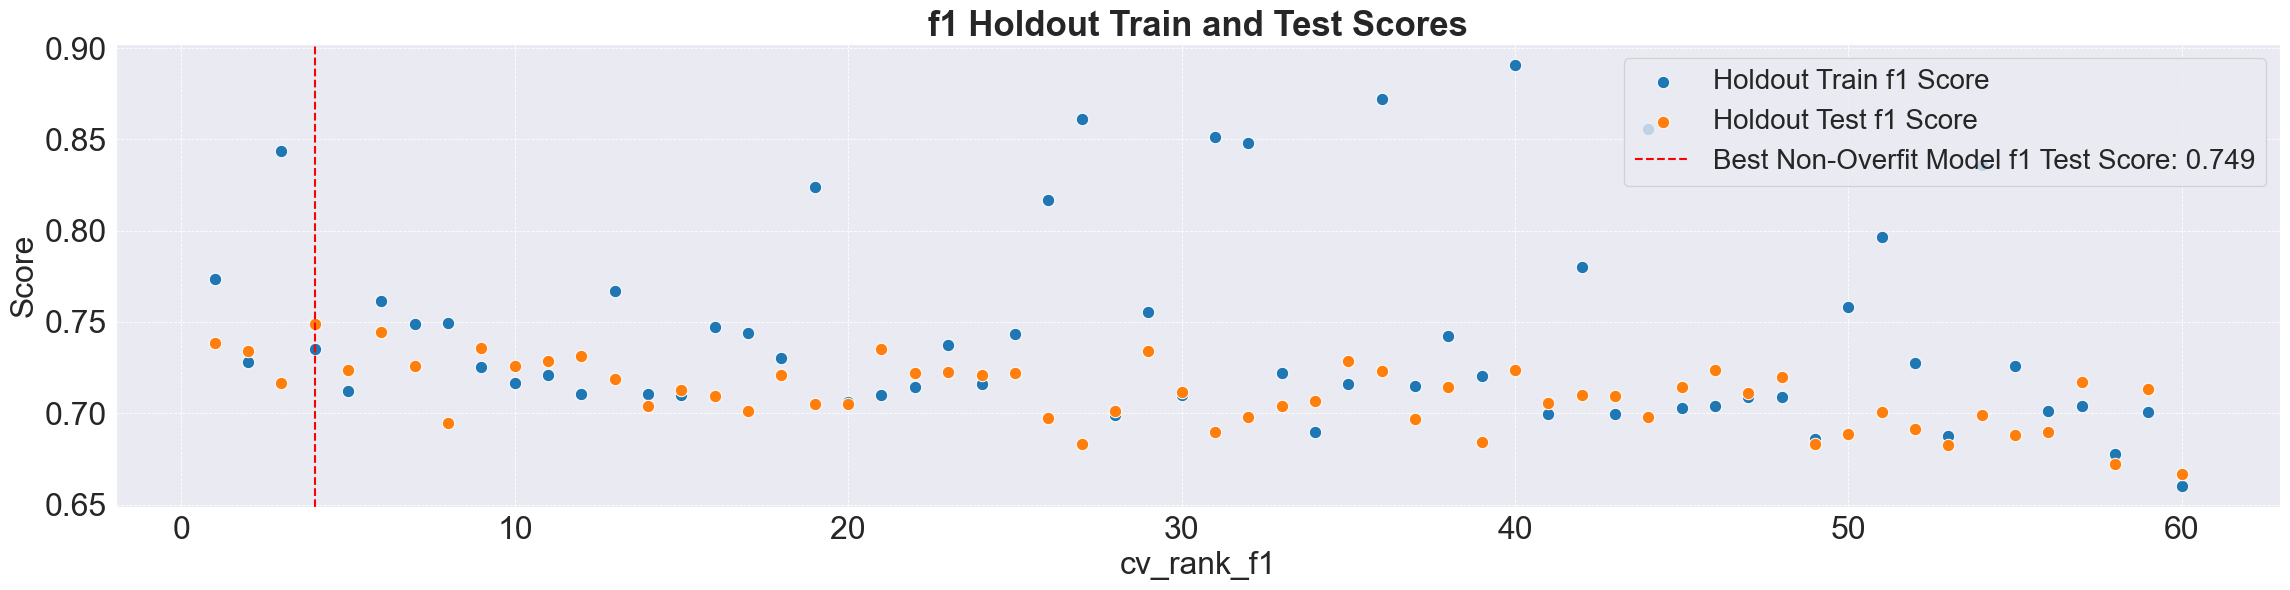

model,train f1 score,test f1 score,mean fit time,mean_test_precision
rf,0.705678,0.717949,2.328135,0.562828
gbc,0.735022,0.748624,1.507520,0.607094


In [31]:
myreload()
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),poly_params={'transformer__num__poly__degree':[1,2,3]},        
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.0035, 0.005, 0.0075, 0.01]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),
                   
    scaler=('scaler', MinMaxScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': [-np.inf], 'selector__max_features': randint(14,27)}, 
    
    estimator_dicts = [{
        'est_tuple': ('rf', RandomForestClassifier(random_state=rs, n_jobs=-1)),
        'est_params': {
            'n_estimators': randint(100,500),
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': randint(2, 5), #start with no limit
            'min_samples_split': np.linspace(0.005, 0.01, 5), #usually 0.5% to 1%  min # samples required to split an internal node | overfit at lower
            'min_samples_leaf': range(35,60,5), #min samples required to be a leaf node | overfit at lower values |     
            'max_features': ['sqrt', 'log2'],
            'class_weight': ['balanced_subsample'], #RF benefits from balanced_subsample for imbalanced datasets
            'bootstrap': [True],'oob_score': [False], 
            'max_samples': uniform(0.1,0.8),
        }
    },
    {
        'est_tuple': ('gbc', GradientBoostingClassifier(verbose=0, random_state=rs)), 
        'est_params': {
            'loss': ['log_loss'], #Generaly default works wells #'exponential', 
            'learning_rate': [0.01, 0.1], #0.1 good starting point. 
            'n_estimators': range(100,1001,100), 
            #Most important tree parameters first 
            'max_depth': range(2,5,1), #**range(4, 8), #normally 5-8 (8 for large datasets)
            'min_samples_split': np.linspace(0.005, 0.01, 5), #usually 0.5% to 1% 
            #Fine Tuning 
            'min_samples_leaf': range(35,60,5), #smaller for imbalanced dataset
            'max_features': ['sqrt', 'log2'], 
            'subsample':np.linspace(0.5, 0.9, 6), #Stochastic sample size
            'criterion': ['friedman_mse', 'squared_error'], 
        }},], 
    set_name= 'ht_ens_set4', cv=5, n_iter=60, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

#### Set 5 narrow down params from Set 4

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.
Fitting 5 folds for each of 80 candidates, totalling 400 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_gbc__criterion,param_gbc__learning_rate,param_gbc__loss,param_gbc__max_depth,param_gbc__max_features,param_gbc__min_samples_leaf,param_gbc__min_samples_split,param_gbc__n_estimators,param_gbc__subsample,param_over__k_neighbors,param_over__sampling_strategy,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision
1,0.722719,Yes,0.756757,0.735346,3.909149,0.618579,squared_error,0.010000,log_loss,4,log2,56,0.007250,1200,0.834000,208,0.430000,25,-inf,0,2
2,0.719036,No,0.737160,0.738739,3.343696,0.610441,squared_error,0.010000,log_loss,3,sqrt,49,0.006375,1200,0.762000,178,0.430000,26,-inf,0.005000,8
3,0.719021,Yes,0.750462,0.710952,4.278853,0.617135,squared_error,0.010000,log_loss,4,log2,56,0.005500,1300,0.798000,317,0.430000,16,-inf,0.004000,3
4,0.717452,Yes,0.761553,0.725953,3.961844,0.621571,squared_error,0.010000,log_loss,4,log2,42,0.007250,1200,0.690000,208,0.430000,17,-inf,0.002000,1


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_gbc__criterion,param_gbc__learning_rate,param_gbc__loss,param_gbc__max_depth,param_gbc__max_features,param_gbc__min_samples_leaf,param_gbc__min_samples_split,param_gbc__n_estimators,param_gbc__subsample,param_over__k_neighbors,param_over__sampling_strategy,param_selector__max_features,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision,holdout_rank_f1
27,0.709779,No,0.728710,0.741935,3.226295,0.607626,squared_error,0.01,log_loss,3,log2,49,0.00725,1100,0.726,202,0.43,19,-inf,0.002,12,1
44,0.703996,No,0.720527,0.739823,3.197209,0.584533,squared_error,0.01,log_loss,2,sqrt,49,0.0055,1500,0.798,175,0.43,16,-inf,0.005,41,2
2,0.719036,No,0.737160,0.738739,3.343696,0.610441,squared_error,0.01,log_loss,3,sqrt,49,0.006375,1200,0.762,178,0.43,26,-inf,0.005,8,3
11,0.714328,No,0.719527,0.738516,2.576546,0.594927,squared_error,0.01,log_loss,2,sqrt,42,0.0055,1000,0.834,256,0.43,26,-inf,0.005,28,4


<Figure size 640x480 with 0 Axes>

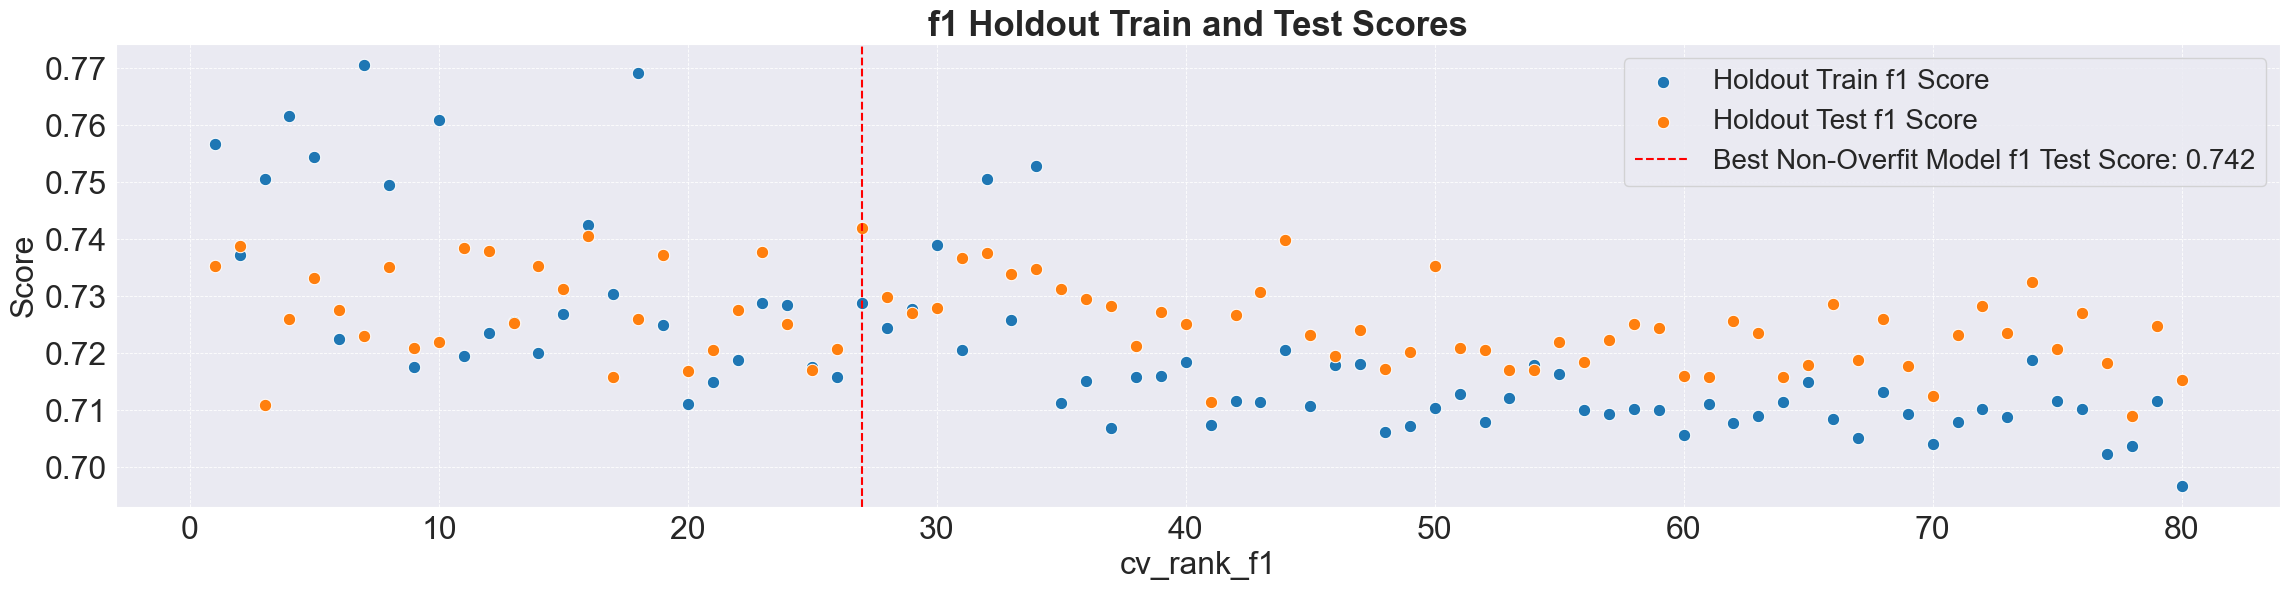

In [35]:
myreload()
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(degree=1, include_bias=False)),        
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.002, 0.003, 0.004, 0.005, 0.006]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder(drop='if_binary'))),
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.43, 0.43, 5), 'over__k_neighbors': range(140, 321)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),
                   
    scaler=('scaler', MinMaxScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': [-np.inf], 'selector__max_features': randint(14,27)}, 
    
    estimator_dicts = [
    {
        'est_tuple': ('gbc', GradientBoostingClassifier(verbose=0, random_state=rs)), 
        'est_params': {
            'loss': ['log_loss'], #Generaly default works wells #'exponential', 
            'learning_rate': [0.005, 0.01], #0.1 good starting point. 
            'n_estimators': range(300,1501,100), 
            #Most important tree parameters first 
            'max_depth': range(2,5,1), #**range(4, 8), #normally 5-8 (8 for large datasets)
            'min_samples_split': np.linspace(0.0055, 0.009, 5), #usually 0.5% to 1% 
            #Fine Tuning 
            'min_samples_leaf': range(35,60,7), #smaller for imbalanced dataset
            'max_features': ['sqrt', 'log2'], 
            'subsample':np.linspace(0.69, 0.87, 6), #Stochastic sample size
            'criterion': ['squared_error'],  #'friedman_mse', 
        }},], 
    set_name= 'ht_ens_set5', cv=5, n_iter=80, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

In [ ]:
Set 4 was best

#### Set 4: CatBoostEncoder with parameters.  Also decreased learning rate and increased min_samples_split

Fitting 5 folds for each of 40 candidates, totalling 200 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_transformer__ohe__drop,param_transformer__num__poly__degree,param_transformer__cat__rest_encoder__sigma,param_transformer__cat__rest_encoder__a,param_transformer__cat__combiner__rare_to_value,param_gbc__subsample,param_gbc__n_estimators,param_gbc__min_samples_split,param_gbc__min_samples_leaf,param_gbc__max_features,param_gbc__max_depth,param_gbc__loss,param_gbc__learning_rate,param_gbc__criterion,rank_test_precision_weighted
1,0.945473,Yes,0.955766,0.952411,15.984582,0.944959,if_binary,1,0.100000,1,0,0.820000,3000,0.012500,40,sqrt,4,log_loss,0.003000,friedman_mse,1
2,0.943744,Yes,0.955058,0.952180,14.172688,0.943523,if_binary,1,0.100000,1.300000,0.002500,0.820000,2400,0.012500,40,sqrt,4,log_loss,0.003000,friedman_mse,2
3,0.943186,Yes,0.956564,0.951567,14.668794,0.942905,if_binary,1,0.100000,1.300000,0.002500,0.660000,2300,0.012500,45,sqrt,5,log_loss,0.003000,friedman_mse,3
4,0.942992,Yes,0.961632,0.946757,24.008107,0.942891,if_binary,2,0.100000,1.200000,0.005000,0.660000,3000,0.012500,40,sqrt,3,log_loss,0.005000,friedman_mse,4


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_transformer__ohe__drop,param_transformer__num__poly__degree,param_transformer__cat__rest_encoder__sigma,param_transformer__cat__rest_encoder__a,param_transformer__cat__combiner__rare_to_value,param_gbc__subsample,param_gbc__n_estimators,param_gbc__min_samples_split,param_gbc__min_samples_leaf,param_gbc__max_features,param_gbc__max_depth,param_gbc__loss,param_gbc__learning_rate,param_gbc__criterion,rank_test_precision_weighted,holdout_rank_f1_weighted
1,0.945473,Yes,0.955766,0.952411,15.984582,0.944959,if_binary,1,0.1,1,0,0.82,3000,0.0125,40,sqrt,4,log_loss,0.003,friedman_mse,1,1
2,0.943744,Yes,0.955058,0.952180,14.172688,0.943523,if_binary,1,0.1,1.3,0.0025,0.82,2400,0.0125,40,sqrt,4,log_loss,0.003,friedman_mse,2,2
3,0.943186,Yes,0.956564,0.951567,14.668794,0.942905,if_binary,1,0.1,1.3,0.0025,0.66,2300,0.0125,45,sqrt,5,log_loss,0.003,friedman_mse,3,3
7,0.942148,Yes,0.952621,0.951242,11.297346,0.942165,if_binary,1,0.1,1.3,0.0025,0.58,1900,0.018125,45,sqrt,4,log_loss,0.003,friedman_mse,7,4


No non-overfit models were found. Consider re-running the function with a houldout_threshold > 0


<Figure size 640x480 with 0 Axes>

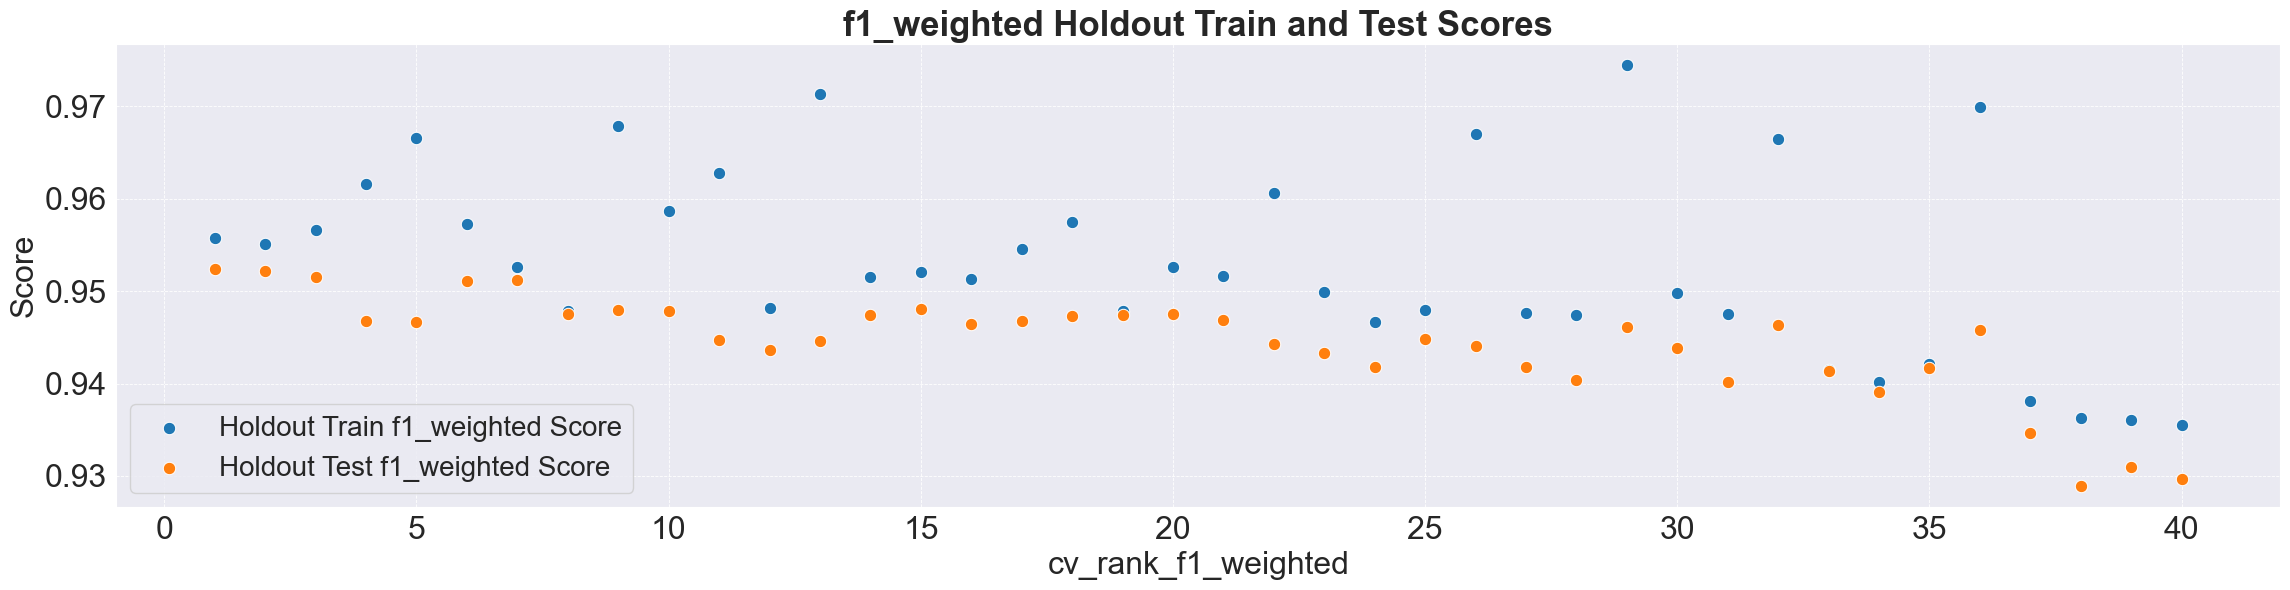

In [135]:

tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),poly_params={'transformer__num__poly__degree':[1,2,3]},           
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075, 0.01]}, #leave as is
    
    cat_encoder=('rest_encoder', CatBoostEncoder(random_state=rs)),
    cat_encoder_params={'transformer__cat__rest_encoder__a': [1,1.2,1.3,1.4], 
                       'transformer__cat__rest_encoder__sigma': [0.1, 0.2]}, 
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                   
    scaler=('scaler', RobustScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    estimator_dicts = [
    {
        'est_tuple': ('gbc', GradientBoostingClassifier(verbose=0, random_state=rs)), 
        'est_params': {
            'loss': ['log_loss'], #Generaly default works wells #'exponential'], 
            'learning_rate': [0.001, 0.003, 0.005], #last round was almost good at 0.1 #uniform(0.0005, 0.0011), #0.1 good starting point. Set and tune tree params #[0.01, 0.05, 0.1, 0.2], 
            'n_estimators': range(1700,3001,100),#ideal range for 0.1 learning rate 
            #Most important tree parameters first 
            'max_depth': [2,3,4,5], #last round had a great model at depth =2, #range(4, 8),(8 for large datasets)
            'min_samples_split': np.linspace(0.0125, 0.02, 5), #last round 0.00875, #usually 0.5% to 1% 
            #Fine Tuning 
            'min_samples_leaf': [40, 45, 50], #last round 35, #randint(10,51),  #smaller for imbalanced dataset
            'max_features': ['sqrt'],  #last round did well with sqrt 'log2'], #range(1000,2000), #
            'subsample': np.linspace(0.5, 0.9, 6), #last round 0.74, 0.82  #[0.65, 0.7,0.75,0.8], #Stochastic sample size
            'criterion': ['friedman_mse'] #last round had a great friedman, 'squared_error'], 
        }},], set_name= 'ht_ens_set4', cv=5, n_iter=40, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

#### Set 5: Restrict poly degree to 1, adjust sigma, reduce rare_to_value, lower learning_rate, increase estimators, recenter min_samples_split around 1.25%, adjust min_samples_leaf

Fitting 5 folds for each of 50 candidates, totalling 250 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_transformer__ohe__drop,param_transformer__num__poly__degree,param_transformer__cat__rest_encoder__sigma,param_transformer__cat__rest_encoder__a,param_transformer__cat__combiner__rare_to_value,param_gbc__subsample,param_gbc__n_estimators,param_gbc__min_samples_split,param_gbc__min_samples_leaf,param_gbc__max_features,param_gbc__max_depth,param_gbc__loss,param_gbc__learning_rate,param_gbc__criterion,rank_test_precision_weighted
1,0.945316,Yes,0.954923,0.952315,16.420325,0.944965,if_binary,1,0.050000,1.400000,0,0.740000,3200,0.011250,40,sqrt,4,log_loss,0.002000,friedman_mse,2
2,0.945242,Yes,0.956262,0.950822,17.201167,0.945385,if_binary,1,0.100000,1.200000,0.003500,0.740000,2600,0.015000,40,sqrt,5,log_loss,0.002000,friedman_mse,1
3,0.944777,Yes,0.957424,0.950106,15.125909,0.944340,if_binary,1,0.150000,1,0,0.580000,2900,0.011250,45,sqrt,5,log_loss,0.003000,friedman_mse,7
4,0.944640,Yes,0.957939,0.950305,14.982106,0.944388,if_binary,1,0.150000,1.200000,0,0.820000,2400,0.010000,40,sqrt,4,log_loss,0.004000,friedman_mse,6


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_transformer__ohe__drop,param_transformer__num__poly__degree,param_transformer__cat__rest_encoder__sigma,param_transformer__cat__rest_encoder__a,param_transformer__cat__combiner__rare_to_value,param_gbc__subsample,param_gbc__n_estimators,param_gbc__min_samples_split,param_gbc__min_samples_leaf,param_gbc__max_features,param_gbc__max_depth,param_gbc__loss,param_gbc__learning_rate,param_gbc__criterion,rank_test_precision_weighted,holdout_rank_f1_weighted
45,0.941517,No,0.945076,0.945705,9.288891,0.941615,if_binary,1,0.15,1,0.003,0.82,2200,0.01125,47,sqrt,2,log_loss,0.002,friedman_mse,47,1
49,0.941038,No,0.944321,0.944457,8.774056,0.941173,if_binary,1,0.15,1,0.0035,0.5,2200,0.0125,40,sqrt,2,log_loss,0.002,friedman_mse,48,2
22,0.943317,Yes,0.960087,0.954146,15.910476,0.943136,if_binary,1,0.15,1.4,0.002,0.5,3400,0.01375,45,sqrt,5,log_loss,0.004,friedman_mse,25,3
1,0.945316,Yes,0.954923,0.952315,16.420325,0.944965,if_binary,1,0.05,1.4,0,0.74,3200,0.01125,40,sqrt,4,log_loss,0.002,friedman_mse,2,4


<Figure size 640x480 with 0 Axes>

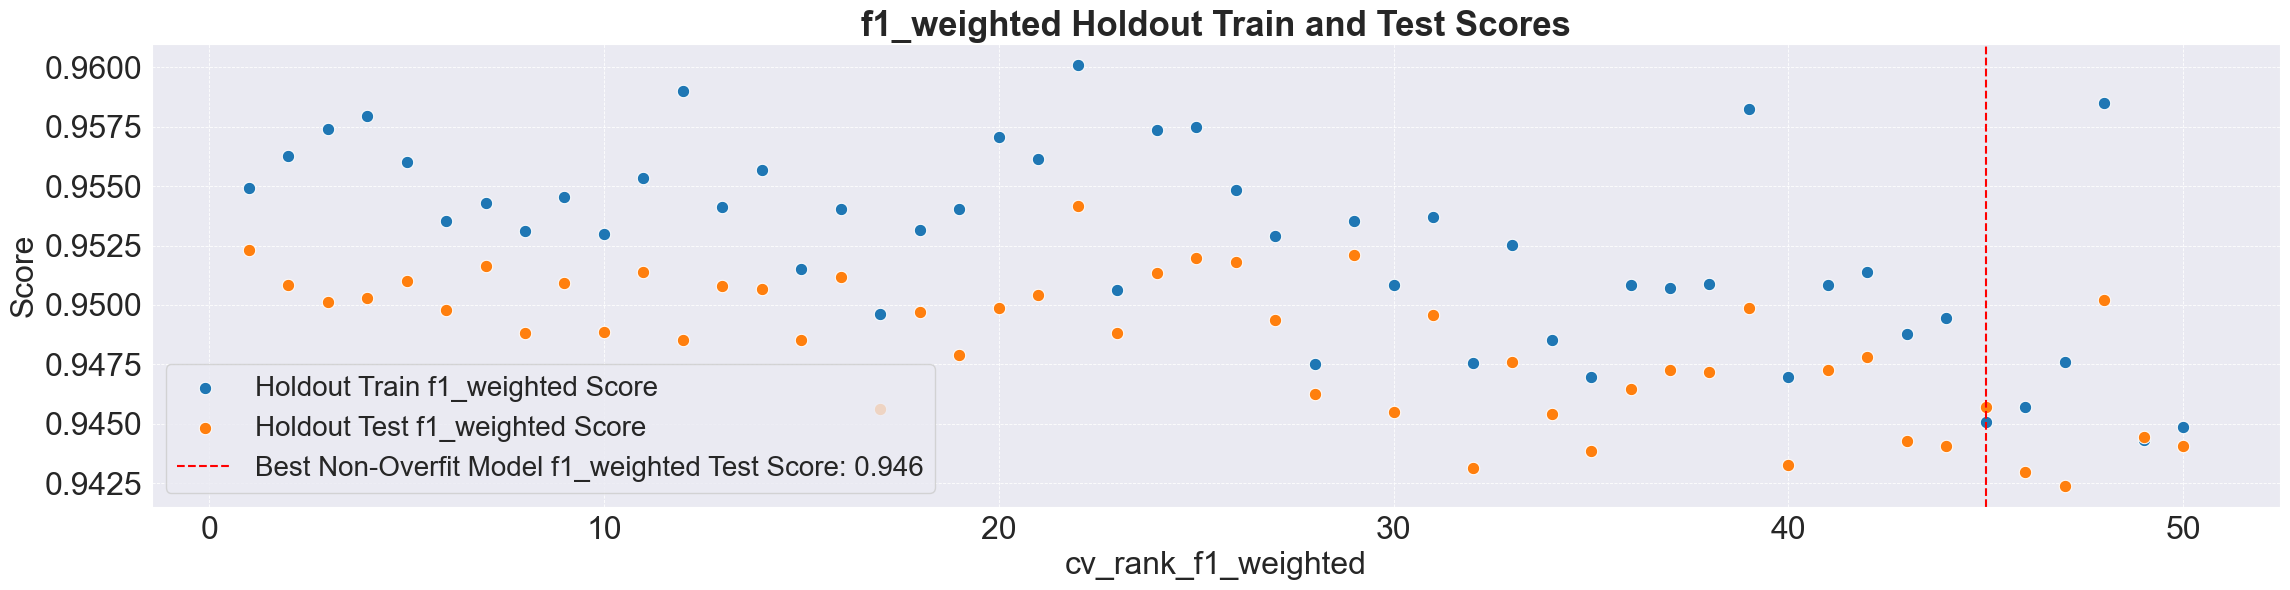

In [136]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),poly_params={'transformer__num__poly__degree':[1]},           
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.002, 0.0025, 0.003, 0.0035]},
    
    cat_encoder=('rest_encoder', CatBoostEncoder(random_state=rs)),
    cat_encoder_params={'transformer__cat__rest_encoder__a': [1,1.2,1.3,1.4], 
                       'transformer__cat__rest_encoder__sigma': [0.05, 0.1, 0.15]}, 
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                   
    scaler=('scaler', RobustScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    estimator_dicts = [
    {
        'est_tuple': ('gbc', GradientBoostingClassifier(verbose=0, random_state=rs)), 
        'est_params': {
            'loss': ['log_loss'], 
            'learning_rate': [0.002, 0.003, 0.004], 
            'n_estimators': range(2000,3501,100),
            #Most important tree parameters first 
            'max_depth': [2,3,4,5], 
            'min_samples_split': np.linspace(0.01, 0.015, 5),
            #Fine Tuning 
            'min_samples_leaf': [37, 40, 43, 45, 47], 
            'max_features': ['sqrt'],  
            'subsample': np.linspace(0.5, 0.9, 6), 
            'criterion': ['friedman_mse'] 
        }},], set_name= 'ht_ens_set5', cv=5, n_iter=50, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

In [142]:
#### Set 6: Repeat Set 5 but with oversampler/underampler

Fitting 5 folds for each of 60 candidates, totalling 300 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_transformer__ohe__drop,param_transformer__num__poly__degree,param_transformer__cat__rest_encoder__sigma,param_transformer__cat__rest_encoder__a,param_transformer__cat__combiner__rare_to_value,param_over__sampling_strategy,param_over__k_neighbors,param_gbc__subsample,param_gbc__n_estimators,param_gbc__min_samples_split,param_gbc__min_samples_leaf,param_gbc__max_features,param_gbc__max_depth,param_gbc__loss,param_gbc__learning_rate,param_gbc__criterion,rank_test_precision_weighted
1,0.938803,Yes,0.949389,0.939413,13.593864,0.947170,if_binary,1,0.050000,1.400000,0,0.450000,225,0.740000,3000,0.010000,43,sqrt,5,log_loss,0.004000,friedman_mse,9
2,0.937907,Yes,0.943572,0.938939,10.748785,0.947153,if_binary,1,0.050000,1.200000,0,0.500000,186,0.500000,3200,0.015000,45,sqrt,4,log_loss,0.003000,friedman_mse,10
3,0.937893,Yes,0.946064,0.937846,12.411945,0.947444,if_binary,1,0.100000,1.400000,0,0.425000,226,0.580000,3500,0.015000,40,sqrt,5,log_loss,0.003000,friedman_mse,6
4,0.937445,Yes,0.945064,0.935814,10.543534,0.948107,if_binary,1,0.100000,1.200000,0,0.475000,153,0.740000,2200,0.012500,40,sqrt,5,log_loss,0.004000,friedman_mse,1


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_transformer__ohe__drop,param_transformer__num__poly__degree,param_transformer__cat__rest_encoder__sigma,param_transformer__cat__rest_encoder__a,param_transformer__cat__combiner__rare_to_value,param_over__sampling_strategy,param_over__k_neighbors,param_gbc__subsample,param_gbc__n_estimators,param_gbc__min_samples_split,param_gbc__min_samples_leaf,param_gbc__max_features,param_gbc__max_depth,param_gbc__loss,param_gbc__learning_rate,param_gbc__criterion,rank_test_precision_weighted,holdout_rank_f1_weighted
32,0.932525,No,0.933844,0.934830,8.850067,0.946687,if_binary,1,0.1,1.3,0.0035,0.5,156,0.66,2500,0.0125,40,sqrt,3,log_loss,0.003,friedman_mse,23,1
30,0.932566,No,0.932558,0.933898,7.539551,0.946802,if_binary,1,0.1,1.2,0.0035,0.475,264,0.5,3300,0.01375,40,sqrt,2,log_loss,0.003,friedman_mse,17,2
42,0.931377,No,0.929924,0.931283,5.544605,0.946630,if_binary,1,0.05,1.3,0.0035,0.425,296,0.74,2000,0.01375,43,sqrt,2,log_loss,0.003,friedman_mse,24,3
1,0.938803,Yes,0.949389,0.939413,13.593864,0.947170,if_binary,1,0.05,1.4,0,0.45,225,0.74,3000,0.01,43,sqrt,5,log_loss,0.004,friedman_mse,9,4


<Figure size 640x480 with 0 Axes>

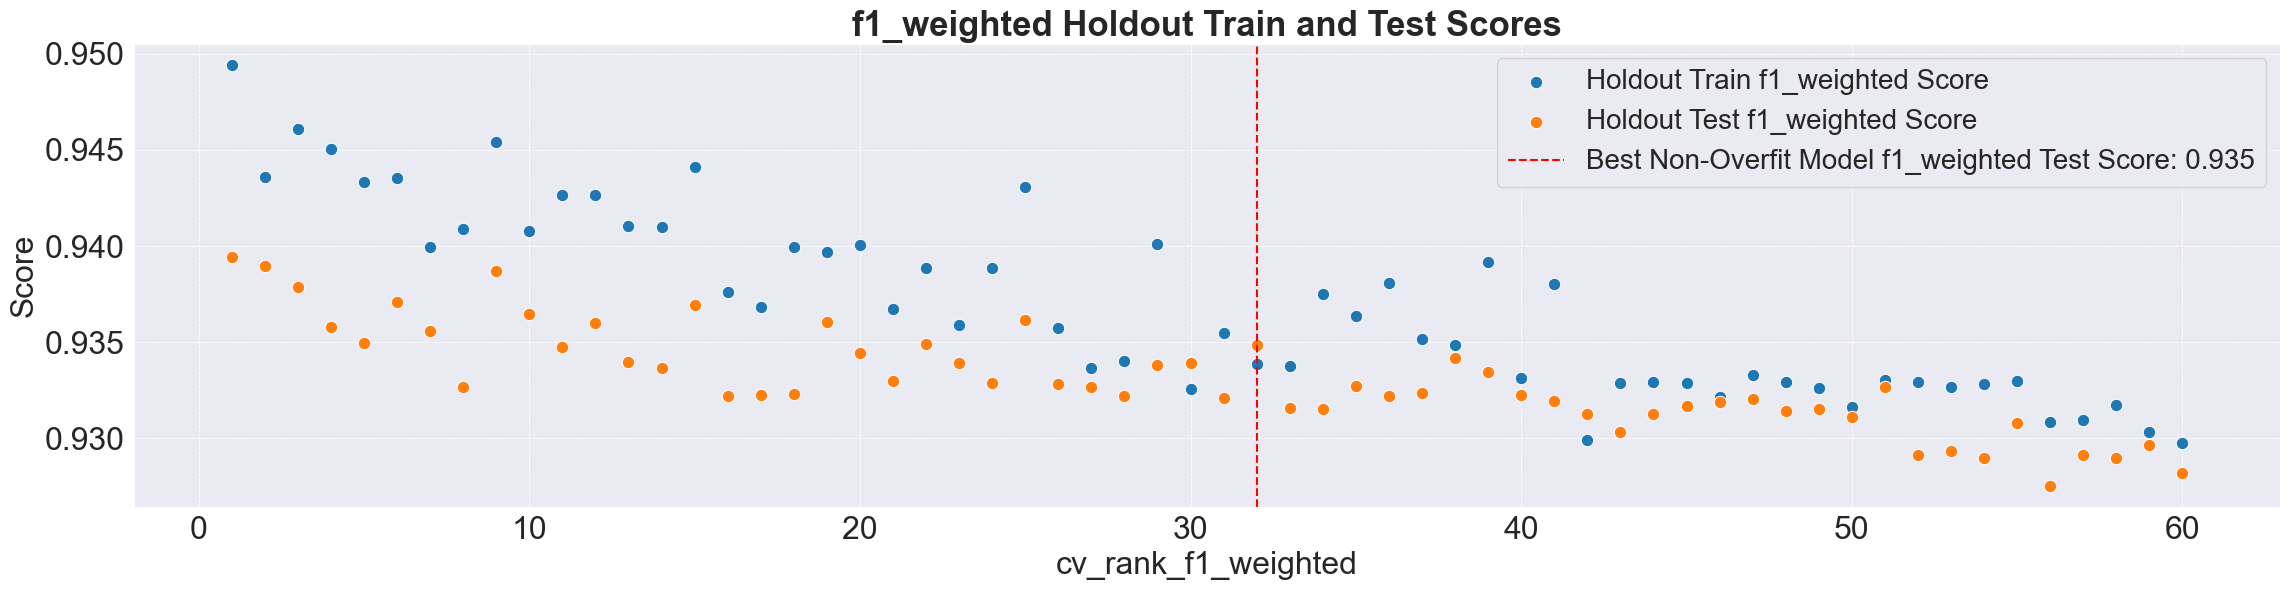

In [144]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),poly_params={'transformer__num__poly__degree':[1]},           
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.002, 0.0025, 0.003, 0.0035]},
    
    cat_encoder=('rest_encoder', CatBoostEncoder(random_state=rs)),
    cat_encoder_params={'transformer__cat__rest_encoder__a': [1,1.2,1.3,1.4], 
                       'transformer__cat__rest_encoder__sigma': [0.05, 0.1, 0.15]}, 
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.5, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),
                   
    scaler=('scaler', RobustScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    estimator_dicts = [
    {
        'est_tuple': ('gbc', GradientBoostingClassifier(verbose=0, random_state=rs)), 
        'est_params': {
            'loss': ['log_loss'], 
            'learning_rate': [0.002, 0.003, 0.004], 
            'n_estimators': range(2000,3501,100),
            #Most important tree parameters first 
            'max_depth': [2,3,4,5], 
            'min_samples_split': np.linspace(0.01, 0.015, 5),
            #Fine Tuning 
            'min_samples_leaf': [37, 40, 43, 45, 47], 
            'max_features': ['sqrt'],  
            'subsample': np.linspace(0.5, 0.9, 6), 
            'criterion': ['friedman_mse'] 
        }},], set_name= 'ht_ens_set6', cv=5, n_iter=60, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

#### Set 7: Repeat Set 5 but with narrow down parameters

Fitting 5 folds for each of 50 candidates, totalling 250 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_transformer__ohe__drop,param_transformer__num__poly__degree,param_transformer__cat__rest_encoder__sigma,param_transformer__cat__rest_encoder__a,param_transformer__cat__combiner__rare_to_value,param_gbc__subsample,param_gbc__n_estimators,param_gbc__min_samples_split,param_gbc__min_samples_leaf,param_gbc__max_features,param_gbc__max_depth,param_gbc__loss,param_gbc__learning_rate,param_gbc__criterion,rank_test_precision_weighted
1,0.944845,Yes,0.948763,0.946555,11.154074,0.945438,if_binary,1,0.150000,1.100000,0.002500,0.900000,2800,0.012500,43,sqrt,2,log_loss,0.004000,friedman_mse,1
2,0.944839,Yes,0.948969,0.946659,9.823127,0.945433,if_binary,1,0.150000,1.100000,0.002500,0.820000,2700,0.010000,43,sqrt,2,log_loss,0.004000,friedman_mse,2
3,0.944663,Yes,0.947964,0.946039,10.959904,0.945231,if_binary,1,0.150000,1,0.002500,0.900000,2600,0.012500,43,sqrt,2,log_loss,0.004000,friedman_mse,3
4,0.943708,Yes,0.950717,0.949049,12.111409,0.943915,if_binary,1,0.150000,1,0.002000,0.820000,3200,0.010000,47,sqrt,2,log_loss,0.004000,friedman_mse,6


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_transformer__ohe__drop,param_transformer__num__poly__degree,param_transformer__cat__rest_encoder__sigma,param_transformer__cat__rest_encoder__a,param_transformer__cat__combiner__rare_to_value,param_gbc__subsample,param_gbc__n_estimators,param_gbc__min_samples_split,param_gbc__min_samples_leaf,param_gbc__max_features,param_gbc__max_depth,param_gbc__loss,param_gbc__learning_rate,param_gbc__criterion,rank_test_precision_weighted,holdout_rank_f1_weighted
12,0.942550,Yes,0.951676,0.950527,11.362537,0.942419,if_binary,1,0.16,1.1,0,0.66,3100,0.015,45,sqrt,2,log_loss,0.004,friedman_mse,29,1
43,0.941446,Yes,0.952024,0.949686,10.726939,0.941326,if_binary,1,0.16,1,0,0.58,3100,0.0125,47,sqrt,2,log_loss,0.004,friedman_mse,48,2
18,0.942422,Yes,0.952883,0.949584,12.981633,0.942400,if_binary,1,0.16,1.1,0,0.82,3500,0.0125,47,sqrt,2,log_loss,0.004,friedman_mse,30,3
4,0.943708,Yes,0.950717,0.949049,12.111409,0.943915,if_binary,1,0.15,1,0.002,0.82,3200,0.01,47,sqrt,2,log_loss,0.004,friedman_mse,6,4


No non-overfit models were found. Consider re-running the function with a houldout_threshold > 0


<Figure size 640x480 with 0 Axes>

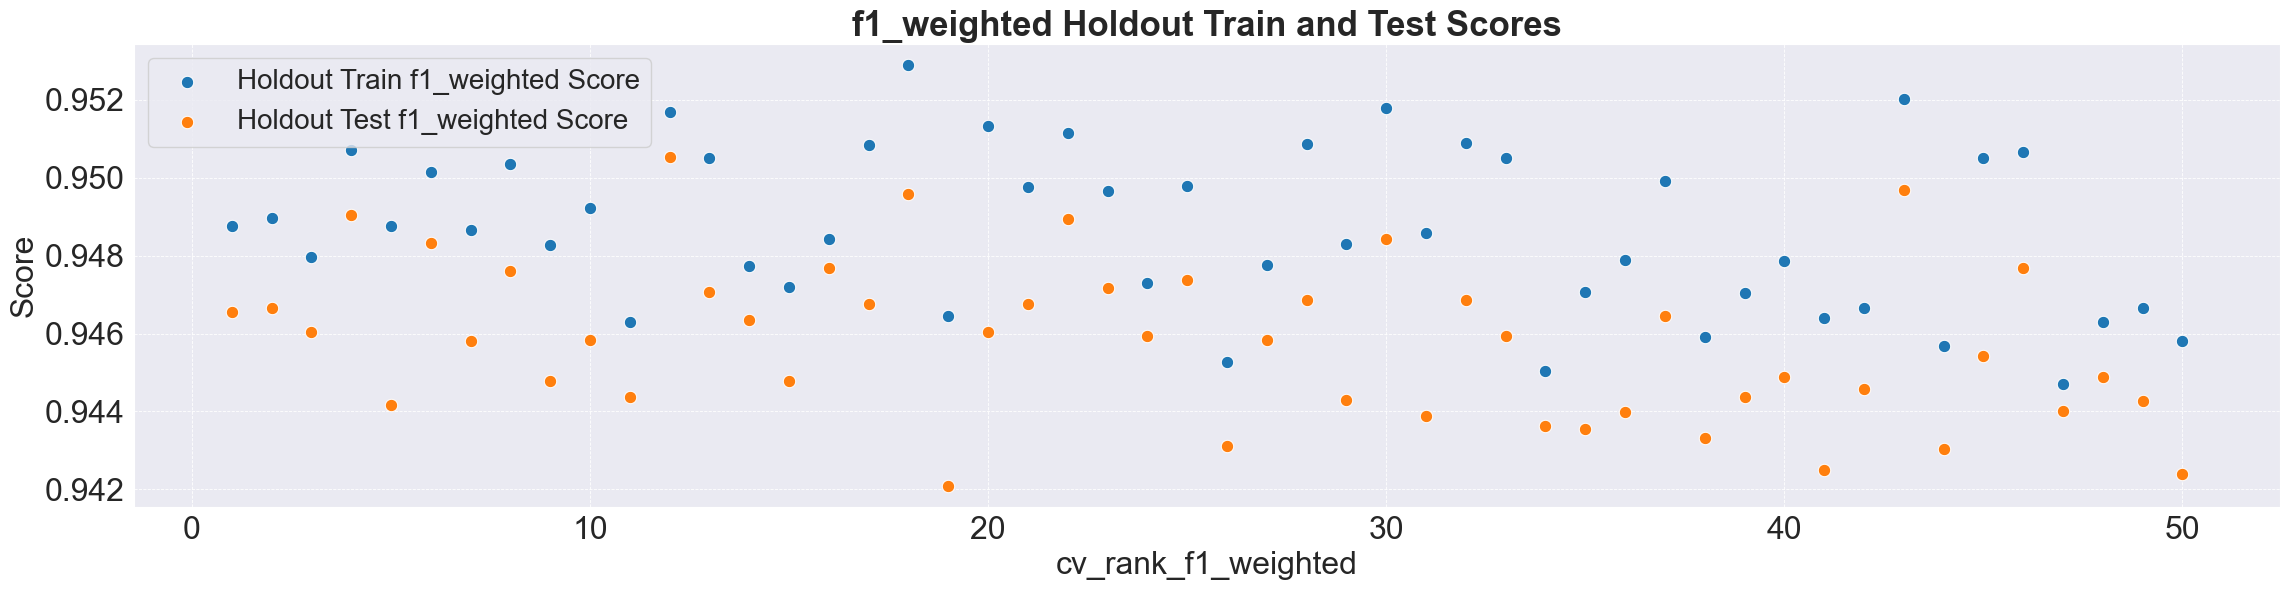

In [143]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),poly_params={'transformer__num__poly__degree':[1]},           
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.002, 0.0025, 0.003, 0.0035]},
    
    cat_encoder=('rest_encoder', CatBoostEncoder(random_state=rs)),
    cat_encoder_params={'transformer__cat__rest_encoder__a': [1,1.1], 
                       'transformer__cat__rest_encoder__sigma': [0.15, 0.16]}, 
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                   
    scaler=('scaler', RobustScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    estimator_dicts = [
    {
        'est_tuple': ('gbc', GradientBoostingClassifier(verbose=0, random_state=rs)), 
        'est_params': {
            'loss': ['log_loss'], 
            'learning_rate': [0.002, 0.003, 0.004], 
            'n_estimators': range(2000,3501,100),
            #Most important tree parameters first 
            'max_depth': [2], 
            'min_samples_split': np.linspace(0.01, 0.015, 5),
            #Fine Tuning 
            'min_samples_leaf': [40, 43, 45, 47, 50], 
            'max_features': ['sqrt'],  
            'subsample': np.linspace(0.5, 0.9, 6), 
            'criterion': ['friedman_mse'] 
        }},], set_name= 'ht_ens_set7', cv=5, n_iter=50, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

#### Set 8 narrow down parameters, increase n_estimators 

Fitting 5 folds for each of 60 candidates, totalling 300 fits


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_transformer__ohe__drop,param_transformer__num__poly__degree,param_transformer__cat__rest_encoder__sigma,param_transformer__cat__rest_encoder__a,param_transformer__cat__combiner__rare_to_value,param_gbc__subsample,param_gbc__n_estimators,param_gbc__min_samples_split,param_gbc__min_samples_leaf,param_gbc__max_features,param_gbc__max_depth,param_gbc__loss,param_gbc__learning_rate,param_gbc__criterion,rank_test_precision
1,0.731055,No,0.762840,0.767184,12.785592,0.732741,if_binary,1,0.180000,1.200000,0.001000,0.850000,3400,0.012500,44,sqrt,2,log_loss,0.004000,friedman_mse,3
2,0.730946,No,0.749810,0.759551,12.269397,0.725196,if_binary,1,0.180000,1.100000,0.001000,0.850000,3000,0.013750,44,sqrt,2,log_loss,0.003700,friedman_mse,37
3,0.730842,No,0.763278,0.763393,15.611055,0.729546,if_binary,1,0.180000,1.100000,0.001000,0.850000,3500,0.015000,47,sqrt,2,log_loss,0.004000,friedman_mse,15
4,0.730503,No,0.765152,0.769912,14.432673,0.732277,if_binary,1,0.170000,1.100000,0.001000,0.850000,3700,0.013750,48,sqrt,2,log_loss,0.004000,friedman_mse,4


cv_rank_f1,cv_f1,is_overfit,train_f1,test_f1,mean_fit_time,mean_test_precision,param_transformer__ohe__drop,param_transformer__num__poly__degree,param_transformer__cat__rest_encoder__sigma,param_transformer__cat__rest_encoder__a,param_transformer__cat__combiner__rare_to_value,param_gbc__subsample,param_gbc__n_estimators,param_gbc__min_samples_split,param_gbc__min_samples_leaf,param_gbc__max_features,param_gbc__max_depth,param_gbc__loss,param_gbc__learning_rate,param_gbc__criterion,rank_test_precision,holdout_rank_f1
4,0.730503,No,0.765152,0.769912,14.432673,0.732277,if_binary,1,0.17,1.1,0.001,0.85,3700,0.01375,48,sqrt,2,log_loss,0.004,friedman_mse,4,1
1,0.731055,No,0.762840,0.767184,12.785592,0.732741,if_binary,1,0.18,1.2,0.001,0.85,3400,0.0125,44,sqrt,2,log_loss,0.004,friedman_mse,3,2
6,0.728949,No,0.763774,0.767184,14.221066,0.728669,if_binary,1,0.18,1.2,0.001,0.79,3700,0.015,45,sqrt,2,log_loss,0.0037,friedman_mse,20,3
7,0.727449,No,0.759091,0.767184,12.246497,0.723007,if_binary,1,0.17,1.1,0.001,0.79,3300,0.0125,45,sqrt,2,log_loss,0.0037,friedman_mse,48,4


<Figure size 640x480 with 0 Axes>

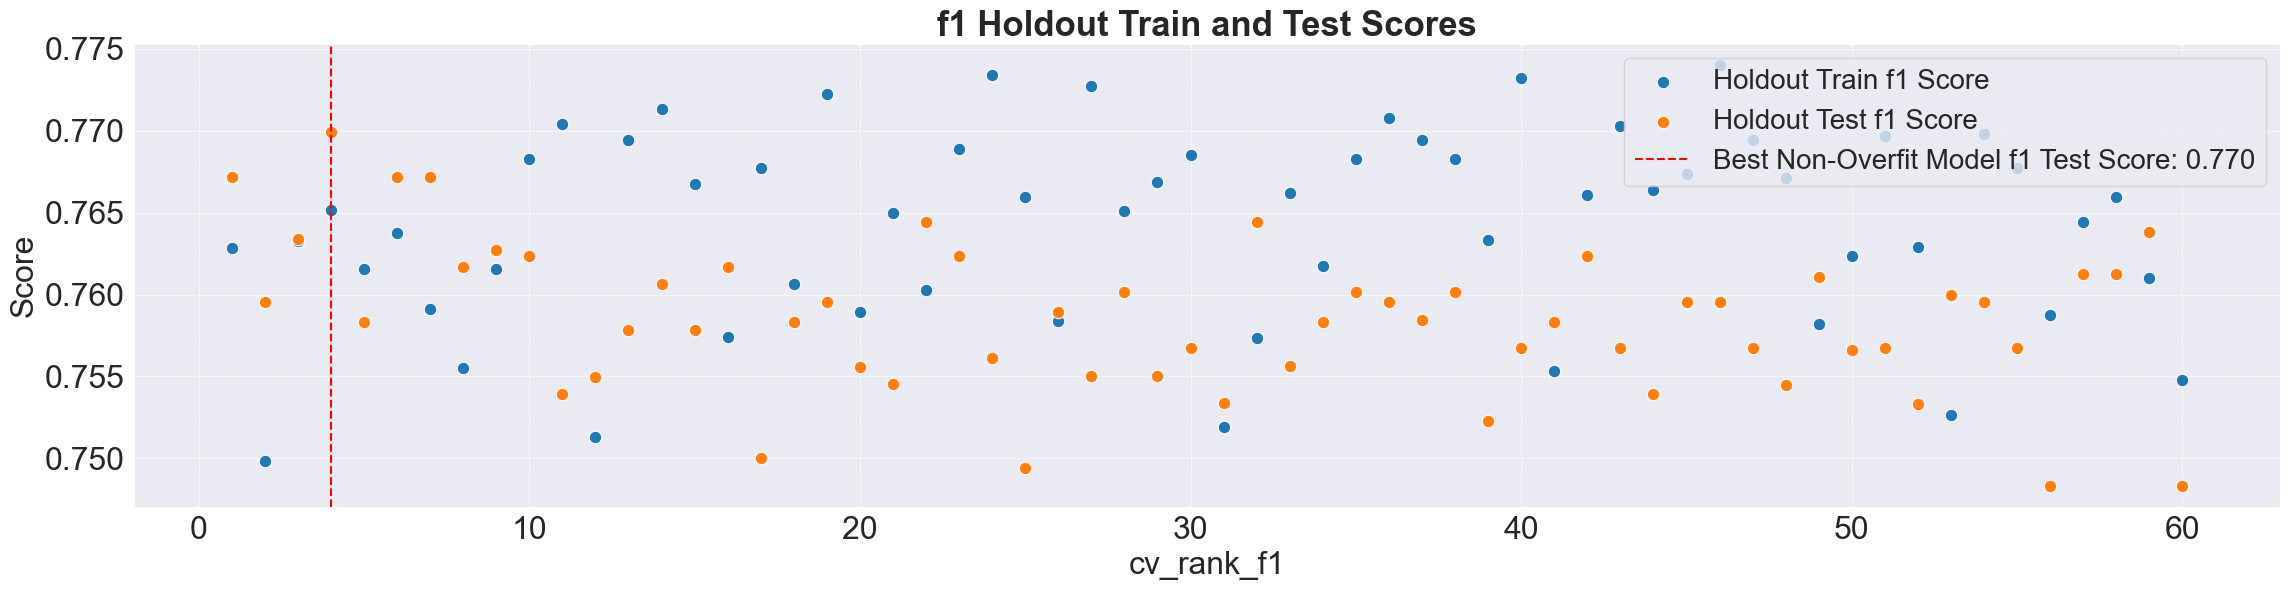

In [36]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = cb_scoring_metrics,refit='f1',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),poly_params={'transformer__num__poly__degree':[1]},           
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.001]},
    
    cat_encoder=('rest_encoder', CatBoostEncoder(random_state=rs)),
    cat_encoder_params={'transformer__cat__rest_encoder__a': [1.1, 1.2], 
                       'transformer__cat__rest_encoder__sigma': [0.16, 0.17, 0.18]}, 
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary']},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                   
    scaler=('scaler', RobustScaler()),  
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    estimator_dicts = [
    {
        'est_tuple': ('gbc', GradientBoostingClassifier(verbose=0, random_state=rs)), 
        'est_params': {
            'loss': ['log_loss'], 
            'learning_rate': [0.0037, 0.004], 
            'n_estimators': range(2900,3801,100),
            #Most important tree parameters first 
            'max_depth': [2], 
            'min_samples_split': np.linspace(0.0125, 0.0175, 5),
            #Fine Tuning 
            'min_samples_leaf': [44, 45, 46, 47,48], 
            'max_features': ['sqrt'],  
            'subsample': np.linspace(0.55, 0.85, 6), 
            'criterion': ['friedman_mse'] 
        }},], set_name= 'ht_ens_set8', cv=5, n_iter=60, summary=True, verbose=1, test_size=0.25, stratify=y,rs=42)

### Summary of Findings
- The best non-overfit model for Logistic Regression was from set 7 and had a test f1 weighted score of 0.9502 with mean fit time 8.6s 
- The best non-overfit model for Gradient Boost Classifier was from set 8 and has a test f1 weight score of 0.9515 and a mean fit time of 13.09s. It also had higher Cross-Validation Results than the Logistic Regression Model (0.944 vs 0.937)